# Path Planning On a Grid with Velocity/Orientation

![1](./Image/1.png)

In this lab your task is to implement `A*` and its suboptimal version - `WA*` (Weighted A*) to solve path planning problems on a grid for an agent with orientation.

> Блок с отступами



**The search space state is considered by the four variables - `<i, j, v, o>`**, where `i` and `j` are the cell's coordinates, `v` - velocity speed, `o` - orientation. It's assumed that the agent have two velocity speeds - 1 and 0. If the agent moves with a constant speed 1, the cost-coefficient of transition is 1. If it needs to accelerate OR to stop, then the transition cost is increased by 0.5. If it needs to accelerate AND to stop, then the transition cost is increased by 1.
The agent can rotate only when the velocity speed is 0. The rotation speed is constant. It requires 1 time unit to rotate for 90 degrees.

You can use the implementation of `A*` you have created in the previous lab. You need to modify it in such a way, that it can take into account agent's velocity and orientation. You also need to create a subomtimal version of the algorithm that uses an inflated heuristic function. After that you need to run some tests and evaluate the influence of suboptimality factor of `WA*` on its performance and solution quality.

<img src="./Image/2new.png" alt="Drawing" style="width: 300px;"/>

Run every cell of the notebook, completing the tasks described in them. Good luck!

In [66]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from sys import float_info
EPS = float_info.epsilon
%matplotlib inline

In [67]:
from google.colab import drive
drive.mount('/content/drive/')
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Data  Image  Lab2.ipynb


In [68]:
%cd /content/drive/My Drive/Planning/Lab2/
!ls

/content/drive/My Drive/Planning/Lab2
Data  Image  Lab2.ipynb


### Grid map representation 

Square grid map class represents the environment for our moving agent

- width -- the number of columns in the grid
- height -- the number of rows in the grid
- cells -- the binary matrix, that represents the grid. 0 - cell is traversable, 1 - cell is blocked

In [69]:
class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self.width = 0
        self.height = 0
        self.cells = []
    

    def ReadFromString(self, cellStr, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self.width = width
        self.height = height
        self.cells = [[0 for _ in range(width)] for _ in range(height)]
        cellLines = cellStr.split("\n")
        i = 0
        j = 0
        for l in cellLines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self.cells[i][j] = 0
                    elif c == '#':
                        self.cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def SetGridCells(self, width, height, gridCells):
        '''
        Initialization of map by list of cells.
        '''
        self.width = width
        self.height = height
        self.cells = gridCells


    def inBounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self.width) and (0 <= i < self.height)
    

    def Traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self.cells[i][j]


    def GetNeighbors(self, i, j, speed, orientation, diagonalMoves = False):
        neighbors = []       
        delta = [(0,1),(-1,0),(0,-1),(1,0)]
        
        if speed == 1:    
            for u in range(0,360,90):
                if orientation == u:
                   a = int(u/90)
            if orientation in range(0,360,90):
              neighbors.append((i, j, 0, orientation))           
              if (self.inBounds(i + delta[a][0], j + delta[a][1]) and self.Traversable(i + delta[a][0], j + delta[a][1])):
                neighbors.append((i + delta[a][0], j + delta[a][1], 1, orientation))

        else:
            neighbors.append((i, j, 1, orientation))  
            for angle in range(0,360,90):
              if orientation != angle:
                neighbors.append((i, j, 0, angle))  

        if diagonalMoves:
          orient = [45,135,225,315]
          delta = [(-1,1),(-1,-1),(1,-1),(1,1)]

          if speed == 1:
       
             for u in range(45,360,90):
                if orientation == u:
                    a = int((u-45)/90)
 
             if orientation in range(45,360,90):
                neighbors.append((i, j, 0, orientation))
                if self.inBounds(i + delta[a][0], j + delta[a][1]) and self.Traversable(i + delta[a][0], j + delta[a][1]) and self.inBounds(i, j + delta[a][1]) and self.Traversable(i, j + delta[a][1]) and self.inBounds(i + delta[a][0], j) and self.Traversable(i + delta[a][0], j):
                   neighbors.append((i + delta[a][0], j + delta[a][1], 1, orientation))


          else:
            for angle in range(0,360,90):
              if orientation != (angle + 45):
                neighbors.append((i, j, 0, (angle + 45))) 
      
        return neighbors

Computes the cost of a transition from cell `(i1, j1)` to cell `(i2, j2)`. In case of 4-connected grid it is always equal to 1. However if other moves are allowed, the cost of a transition may vary.

In [70]:
def ComputeCost(NodeA, NodeB):
    if NodeA.orientation == NodeB.orientation:
      if NodeA.speed == NodeB.speed and NodeA.speed == 1:
        if abs(NodeA.i - NodeB.i) + abs(NodeA.j - NodeB.j) == 1:
            cost = 1 
        else: #diagonal move
            cost = math.sqrt(2)          
      if NodeA.speed != NodeB.speed:
          cost = 0.5
    else:
      if abs(NodeA.orientation - NodeB.orientation) < 181:
        cost = (0.5*abs(NodeA.orientation - NodeB.orientation)/45)
      else:
        cost = (0.5*(360 - abs(NodeA.orientation - NodeB.orientation))/45)
    return cost



### Search Node Representation



In [71]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    You might want to add other fields, methods for Node, depending on how you prefer to implement OPEN/CLOSED further on
    '''

    def __init__(self, i, j, speed=None, orientation=None, g = 0, h = 0, F = None, parent = None, hweight = 1):
        self.i = i
        self.j = j
        self.g = g
        self.h = h * hweight
        self.speed = speed
        self.orientation = orientation
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent
    
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j) and (self.speed == other.speed) and (self.orientation == other.orientation)
    
    def __lt__(self, other): #self < other (self has higher priority)
        return self.F < other.F or (abs(self.F - other.F) < EPS and (self.g > other.g))

### Visualization

In [72]:
def Draw(gridMap : Map, start : Node = None, goal : Node = None, path : list = None, nodesExpanded = None, nodesOpened = None):
    '''
    Auxiliary function that visualizes the enviromnet, the path and OPEN and CLOSED.
    '''
    k = 5
    hIm = gridMap.height * k
    wIm = gridMap.width * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(gridMap.height):
        for j in range(gridMap.width):
            if(gridMap.cells[i][j] == 1):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesOpened is not None:
        for node in nodesOpened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
      if (type(nodesExpanded) == type(YourClosed())):
        for h,node in nodesExpanded.elements.items():
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)
      else:
         for node in nodesExpanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (gridMap.Traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (gridMap.Traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (gridMap.Traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    fig, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    
    


Example of the visualization

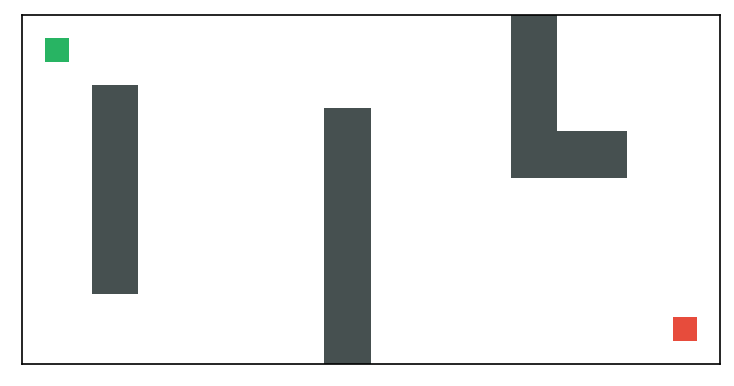

In [73]:
height = 15
width = 30
mapstr = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

testMap = Map()
testMap.ReadFromString(mapstr, width, height)
start = Node(1, 1)
goal = Node(13, 28)
Draw(testMap, start, goal)



### Implementing OPEN and CLOSED
Efficient implementation of OPEN and CLOSED is crucial for any search algorithm. Below you may find basic implementations that use lists to store the elements of OPEN and CLOSED. This is not very efficient. Your task is to create your own implementations.

It's a good idea to modify CLOSED first (as it is pretty straghtforward to do so). Then check that everything is OK, i.e. the search algorithms work faster and the result is correct. Then proceed to modifying OPEN (which is not that trivial as might seem).

PS: You may wish to add additional fields, methods, method-arguments etc. to your implementations.


In [74]:
class OpenBase:

    def __init__(self):
        pass


    def __len__(self):
        pass


    def __iter__(self):
        pass


    def isEmpty(self):
        '''
        isEmpty should inform whether the OPEN is exhausted or not in the former case the search main loop should be interrupted
        '''
        pass


    def AddNode(self, node : Node, *args):
        '''
        AddNode is the method that puts (e.g. inserts or updates) the node to OPEN
        When implementing it do not forget to handle all possible cases:
         - node already in OPEN but the new g-value is better;
         - node already in OPEN but the new g-value is worse;
         - node is not in OPEN yet.
        '''
        pass


    def GetBestNode(self, *args):
        '''
        GetBestNode is the method that 
         i) finds the best node, i.e. the one with the lowest f-value (f=g+h) (for Dijkstra h=0),
         ii) removes it from OPEN and 
         iii) returns it
        '''
        pass



In [75]:
class OpenList (OpenBase):

    def __init__(self):
        self.elements = []
    

    def __iter__(self):
        return iter(self.elements)


    def __len__(self):
        return len(self.elements)


    def isEmpty(self):
        if len(self.elements) != 0:
            return False
        return True
    

    def GetBestNode(self, *args):
        bestF = math.inf
        bestCoord = 0
        for i in range(len(self.elements)):
            if self.elements[i].F < bestF:
                bestCoord = i
                bestF = self.elements[i].F
                
        best = self.elements.pop(bestCoord)
        return best
    

    def AddNode(self, node : Node, *args):
        for existingNode in self.elements:
            if existingNode == node:
                if existingNode.g > node.g:
                    existingNode.g = node.g
                    existingNode.F = node.F
                    existingNode.parent = node.parent
                    return
                else:
                    return
        self.elements.append(node)
        return


In [76]:
class ClosedBase:

    def __init__(self):
        pass


    def __iter__(self):
        pass
    

    def __len__(self):
        pass
    
    
    def AddNode(self, item : Node):
        pass


    def WasExpanded(self, item : Node):
        pass



In [77]:
class ClosedList (ClosedBase):

    
    def __init__(self):
        self.elements = []


    def __iter__(self):
        return iter(self.elements)
    

    def __len__(self):
        return len(self.elements)
    

    def AddNode(self, item : Node):
        '''
        AddNode is the method that inserts the node to CLOSED
        '''
        self.elements.append(item)
     
     
    def WasExpanded(self, item : Node):
        '''
        WasExpanded is the method that checks if a node has been expanded
        '''
        return item in self.elements

In [78]:
class YourOpen (OpenBase):

    
    def __init__(self):
        self.elements = dict()
        self.sortF = dict()
    
    def __iter__(self):
        return iter(self.elements)
    
    def __len__(self):
         return len(self.elements)

    def isEmpty(self):
        return len(self.elements) == 0

    def AddNode(self,node:Node, *args):
            el = self.elements.get(((node.i, node.j), (node.speed, node.orientation)))
            if el:
                if el.g > node.g:
                    mn = el.F
                    self.elements[((node.i, node.j), (node.speed, node.orientation))] = Node(node.i, node.j, node.speed, node.orientation, node.g, node.h, node.F, node.parent)
                    self.sortF[mn].remove(((node.i, node.j), (node.speed, node.orientation)))
                    if (len(self.sortF[mn]) == 0):
                        self.sortF.pop(mn)
    
                    if self.sortF.get(node.F):
                        self.sortF.update({node.F: self.sortF[node.F] + [((node.i, node.j), (node.speed, node.orientation))]})
                    else:
                        self.sortF.update({node.F: [((node.i, node.j), (node.speed, node.orientation))]})
                return
            self.elements.update({((node.i, node.j), (node.speed, node.orientation)): node})
    
            if self.sortF.get(node.F):
                self.sortF.update({node.F: self.sortF[node.F] + [((node.i, node.j), (node.speed, node.orientation))]})
            else:
                self.sortF.update({node.F: [((node.i, node.j), (node.speed, node.orientation))]})
            return

    def GetBestNode(self, *args):
         mn = min(self.sortF)
         k = self.sortF[mn][0]
         if (len(self.sortF[mn])) == 1:
               self.sortF.pop(mn)
         else:
               self.sortF.update({mn: self.sortF[mn][1:]})
         best = self.elements.pop(k)
         return best

In [79]:
class YourClosed (ClosedBase):
    

    def __init__(self):
        self.elements = dict()


    def __iter__(self):
        return iter(self.elements)
    

    def __len__(self):
        return len(self.elements)


    def AddNode(self, item : Node):
        self.elements.update({((item.i, item.j),(item.speed, item.orientation)): item})


    def WasExpanded(self, item : Node):
        return ((item.i, item.j),(item.speed, item.orientation)) in self.elements
        

## Weighted A* algorithm with velocity/orientation

In [80]:
def DiagonalDistance(i1, j1, i2, j2):
     return math.sqrt(abs(abs(j1 - j2) - abs(i1 - i2)) + math.sqrt(2)*min(abs(j1 - j2),abs(i1 - i2) ) )

In [81]:
def ManhattanDistance(i1, j1, i2, j2):
    return (abs(i1 - i2) + abs(j1 - j2))

In [82]:
def EuclideanDistance(i1, j1, i2, j2):
    return math.sqrt((i1 - i2)**2 + (j1 - j2)**2)

In [83]:
def getOrientation(parent, node):
    heading = math.acos((node.j - parent.j)/math.sqrt((node.i - parent.i)**2 + (node.j - parent.j)**2))*180/math.pi
    if parent.i < node.i:
        heading = 360 - heading
    return heading

In [84]:
def WAStar(gridMap : Map, iStart : int, jStart : int, iGoal : int, jGoal : int, heuristicFunction = ManhattanDistance,\
           openType = OpenList, closedType = ClosedList, diagonalMoves = False, hweight = 1.0):

    OPEN = openType()
    CLOSED = closedType()
    start = Node(iStart, jStart, 0, 0, hweight=hweight)
    OPEN.AddNode(start)
    while not OPEN.isEmpty():
        curNode = OPEN.GetBestNode()
        CLOSED.AddNode(curNode)
        if (((curNode.i, curNode.j) == (iGoal, jGoal)) and (curNode.speed == 0)):
            return (True, curNode, CLOSED, OPEN)
        neighbors = gridMap.GetNeighbors(curNode.i, curNode.j, curNode.speed, curNode.orientation, diagonalMoves)
        for n in neighbors:
            newNode = Node(n[0], n[1], n[2], n[3])
            newNode.g = curNode.g + ComputeCost(curNode, newNode)
            newNode.h = hweight * heuristicFunction(newNode.i, newNode.j, iGoal, jGoal)
            newNode.F = newNode.g + newNode.h
            newNode.parent = curNode
            if CLOSED.WasExpanded(newNode):
                continue
            OPEN.AddNode(newNode)
    return False, None, CLOSED, OPEN

### Validating the results


In [85]:
def MakePath(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [86]:
def ReadTaskFromFile(path):
    '''
    Reads map, start/goal positions and true value of path length between given start and goal from file by path. 
    '''

    tasksFile = open(path)
    count = 0
    height = int(tasksFile.readline())
    width = int(tasksFile.readline())
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0

    for l in tasksFile:
        j = 0
        for c in l:
            if c == '.':
                cells[i][j] = 0
            elif c == '#':
                cells[i][j] = 1
            else:
                continue
            
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break
    
    iStart = int(tasksFile.readline())
    jStart = int(tasksFile.readline())
    iGoal = int(tasksFile.readline())
    jGoal = int(tasksFile.readline())
    cardinalLength = float(tasksFile.readline())
    diagonalLength = float(tasksFile.readline())
    return (width, height, cells, iStart, jStart, iGoal, jGoal, cardinalLength, diagonalLength)

`Simpletest` tests the pathfing algorithm on a single simple instance, `Massivetest` - on a series of a move involved instances. Both tests assume that the search function fits the following pattern:


`Search(taskMap, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (pathFound, lastState, CLOSED, OPEN)`, where

- taskMap -- grid
- start.i, start.j -- (i,j) coordinates of the start cell
- goal.i, goal.j -- (i,j) coordinates of the goal cell
- *optional arguments* -- additional parameters of the search function, passed with `*args`. Example of additional parameters you can see at Dijkstra and A* functions
- pathFound -- `True` if path was found, `False` otherwise
- lastState -- last state of the path. `None` if path was not found
- CLOSED -- CLOSED set (at the last step)
- OPEN -- OPEN set (at the last step)

In [87]:
from random import randint
import sys
def SimpleTest(SearchFunction, task, *args):
    '''
    SimpleTest runs SearchFunction on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task

    '''
    
    height = 15
    width = 30
    mapstr = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    taskMap = Map()
    taskMap.ReadFromString(mapstr, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29)]
    cardLengths = [42, 34, 39, 26, 34, 29, 44, 35, 55, 30, 47, 49, 29, 30, 45, 44, 52, 31, 55, 46, 46, 35, 41, 52 ,55]
    diagLengths = [39.31370849898476, 31.313708498984763, 33.39949493661167, 21.72792206135786, 31.485281374238575,\
                       27.656854249492383, 37.39949493661167, 30.72792206135786, 47.47056274847714, 23.39949493661167,\
                       42.89949493661167, 43.39949493661166, 28.414213562373096, 26.89949493661167, 36.97056274847715,\
                       36.38477631085024, 45.970562748477136, 30.82842712474619 ,46.79898987322332, 38.72792206135786,\
                       36.627416997969526, 30.89949493661167, 33.97056274847715, 45.970562748477136, 47.79898987322333]


    if (task is None) or not (0 <= task < 25):
        task = randint(0, 24)


    start = Node(*starts[task])
    goal = Node(*goals[task])
    cardLength = cardLengths[task]
    diagLength = diagLengths[task]
    try:
        result = SearchFunction(taskMap, start.i, start.j, goal.i, goal.j, *args)
        nodesExpanded = result[2]
        nodesOpened = result[3]
        if result[0]:
            path = MakePath(result[1])
            correct = (int(path[1])  == int(cardLength) or abs(float(path[1]) - float(diagLength)) < 1e-6)
            Draw(taskMap, start, goal, path[0], nodesExpanded, nodesOpened)
            print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
        else:
            print("Path not found!")

    except Exception as e:
        print("Execution error")
        tb = sys.exc_info()[2]
        print(e)
        raise e.with_traceback(tb)

In [88]:
def MassiveTest(SearchFunction, *args):
    '''
    MassiveTest runs SearchFunction on set of differnt tasks (from directory Data/) with *args as optional arguments and for every task displays one of these short reports:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task.
    
    Massive test return a dictionary with statistics of path finding. Dictionary contains next fields:
     - "corr" -- the correctness of every path length (True/False)
     - "len" -- the length of every path (0.0 if path not found)
     - "nc" -- the number of created nodes for every task execution
     - "st" -- the number of steps of algorithm for every task execution
    '''
    
    stat = dict()
    stat["corr"] = []
    stat["len"] = []
    stat["nc"] = []
    stat["st"] = []
    taskNum = 9
    taskMap = Map()
    for taskCount in range(taskNum):
        taskFileName = "Data/" + str(taskCount) + ".map"
        width, height, cells, iStart, jStart, iGoal, jGoal, cardinalLength, diagonalLength = ReadTaskFromFile(taskFileName)
        taskMap.SetGridCells(width,height,cells)
        try:
            result = SearchFunction(taskMap, iStart, jStart, iGoal, jGoal, *args)
            nodesExpanded = result[2]
            nodesOpened = result[3]
            if result[0]:
                path = MakePath(result[1])
                stat["len"].append(path[1])
                correct = int(path[1])  == int(cardinalLength) or abs(float(path[1]) - float(diagonalLength)) < 1e-6
                stat["corr"].append(correct)
                #Draw(taskMap, Node(iStart, jStart), Node(iGoal, jGoal), path[0], nodesExpanded, nodesOpened)
                print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
            else:
                print("Path not found!")
                stat["corr"].append(False)
                stat["len"].append(0.0)

            stat["nc"].append(len(nodesOpened) + len(nodesExpanded))
            stat["st"].append(len(nodesExpanded))

        except Exception as e:
             print("Execution error")
             tb = sys.exc_info()[2]
             print(e)
             raise e.with_traceback(tb)

    return stat

Path found! Length: 34.0. Nodes created: 1052. Number of steps: 691. Correct: True
CPU times: user 235 ms, sys: 1.03 ms, total: 236 ms
Wall time: 238 ms
Path found! Length: 34.0. Nodes created: 1052. Number of steps: 691. Correct: True
CPU times: user 224 ms, sys: 2 µs, total: 224 ms
Wall time: 222 ms
Path found! Length: 34.0. Nodes created: 1052. Number of steps: 691. Correct: True
CPU times: user 227 ms, sys: 1.02 ms, total: 228 ms
Wall time: 226 ms
Path found! Length: 34.0. Nodes created: 1052. Number of steps: 691. Correct: True
CPU times: user 234 ms, sys: 10 µs, total: 234 ms
Wall time: 231 ms
Path found! Length: 34.0. Nodes created: 1052. Number of steps: 691. Correct: True
CPU times: user 242 ms, sys: 1.97 ms, total: 244 ms
Wall time: 245 ms
Path found! Length: 34.0. Nodes created: 1052. Number of steps: 691. Correct: True
CPU times: user 233 ms, sys: 1.01 ms, total: 234 ms
Wall time: 232 ms
Path found! Length: 34.0. Nodes created: 1052. Number of steps: 691. Correct: True
CPU 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 34.0. Nodes created: 1052. Number of steps: 691. Correct: True
CPU times: user 226 ms, sys: 6.02 ms, total: 232 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 34.0. Nodes created: 1052. Number of steps: 691. Correct: True
CPU times: user 244 ms, sys: 2.02 ms, total: 246 ms
Wall time: 258 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 34.0. Nodes created: 1052. Number of steps: 691. Correct: True
CPU times: user 233 ms, sys: 1.02 ms, total: 234 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 34.0. Nodes created: 1052. Number of steps: 691. Correct: True
CPU times: user 232 ms, sys: 1 ms, total: 233 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 34.0. Nodes created: 1052. Number of steps: 691. Correct: True
CPU times: user 233 ms, sys: 997 µs, total: 234 ms
Wall time: 236 ms


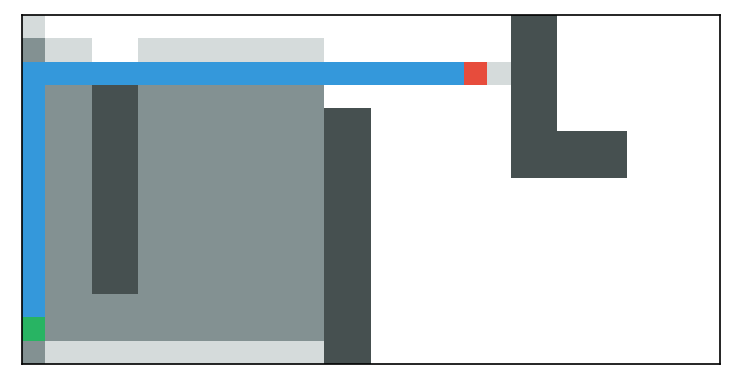

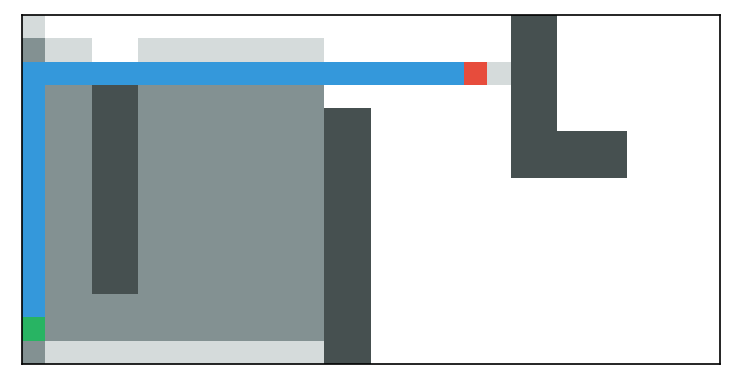

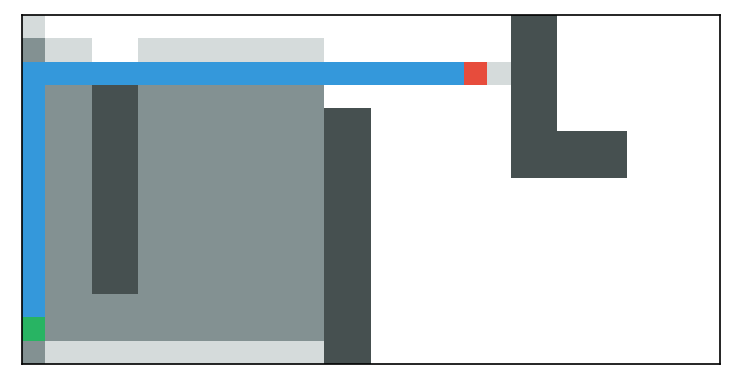

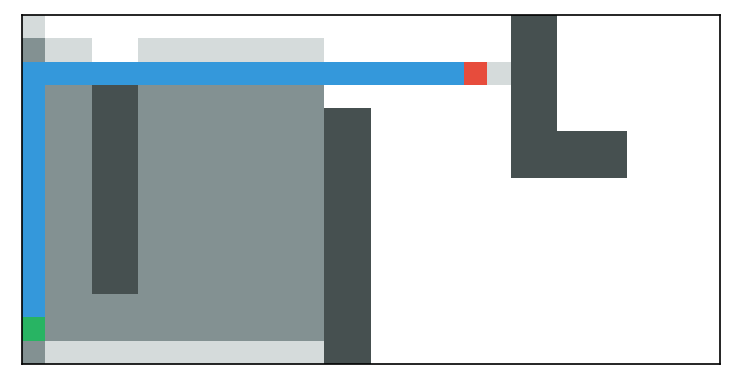

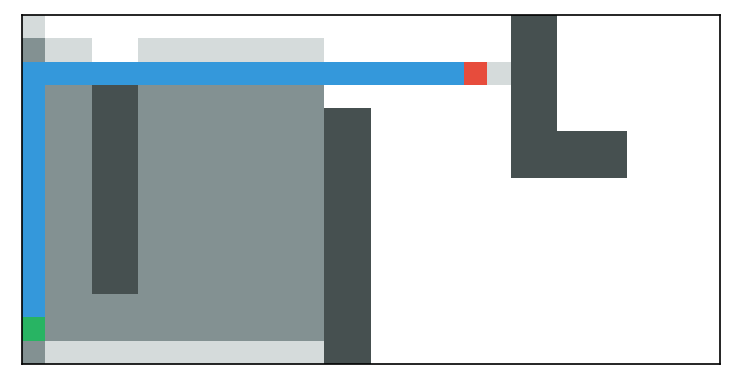

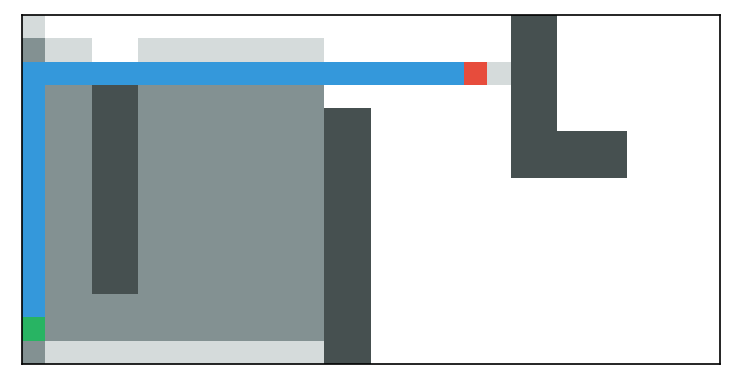

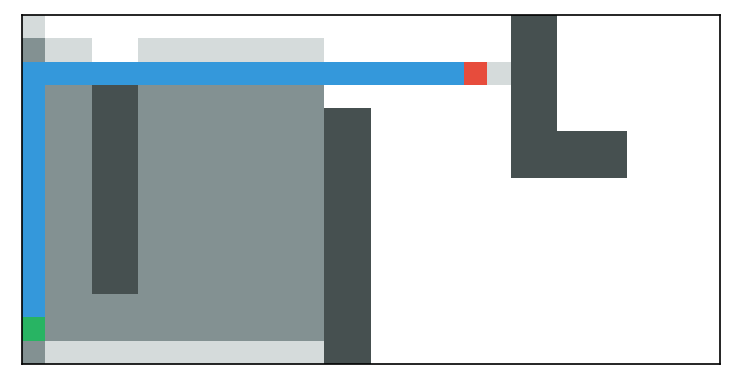

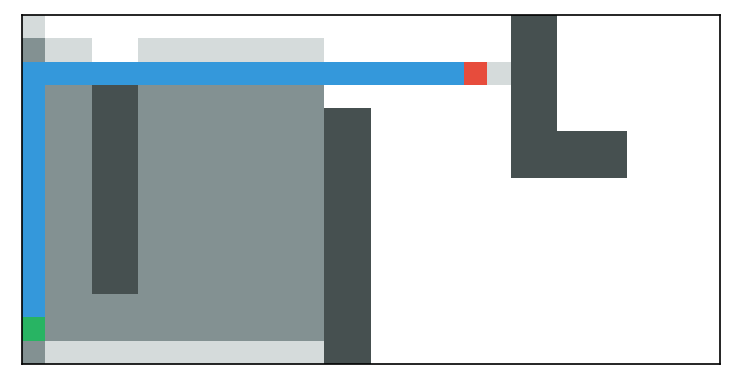

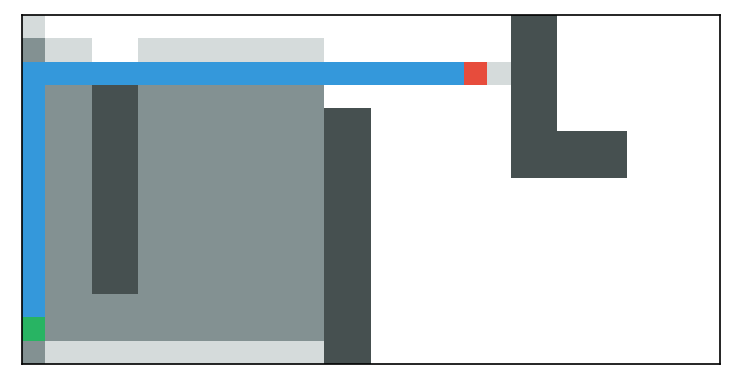

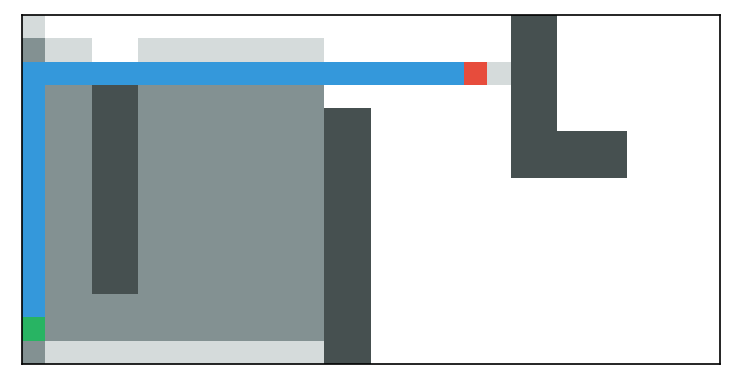

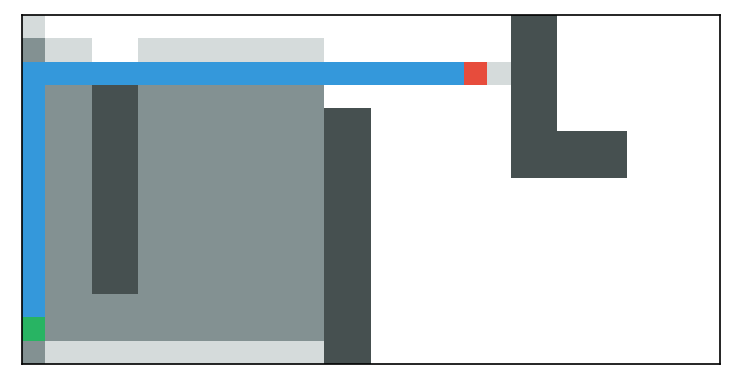

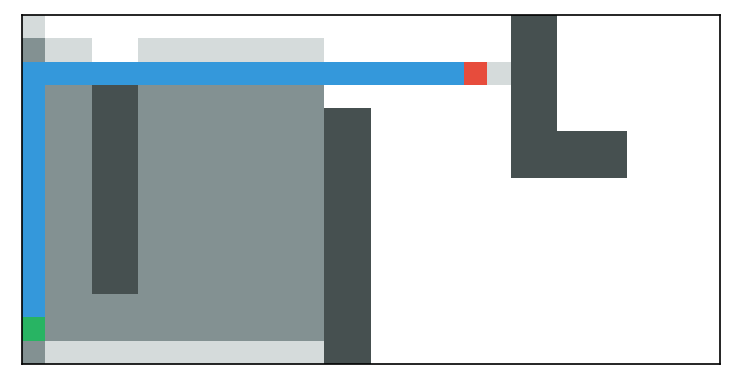

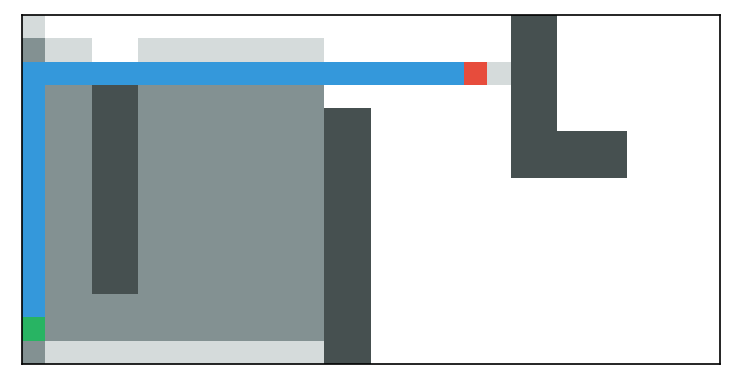

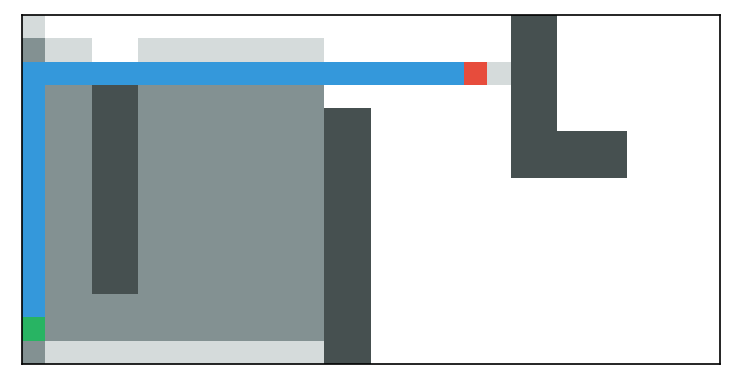

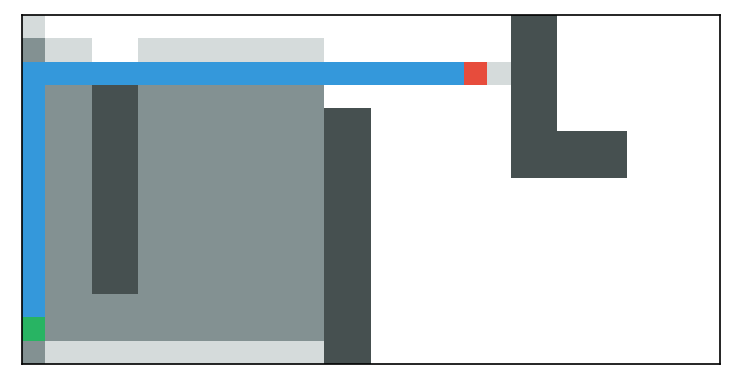

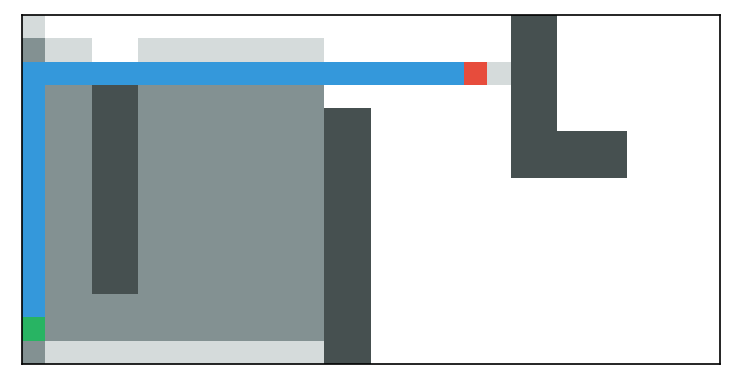

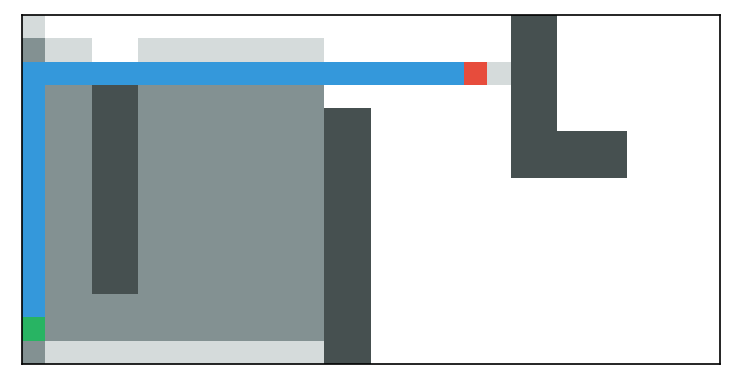

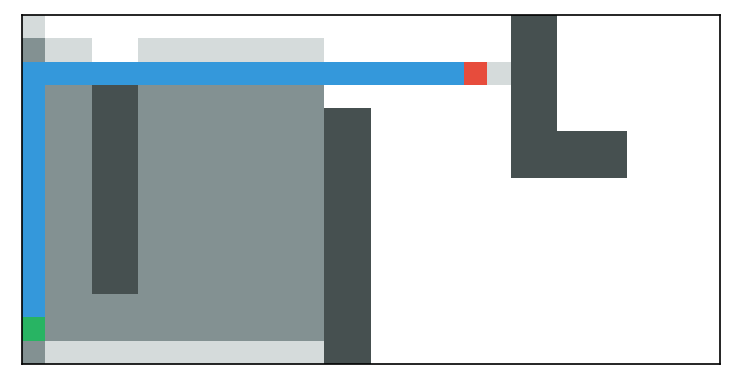

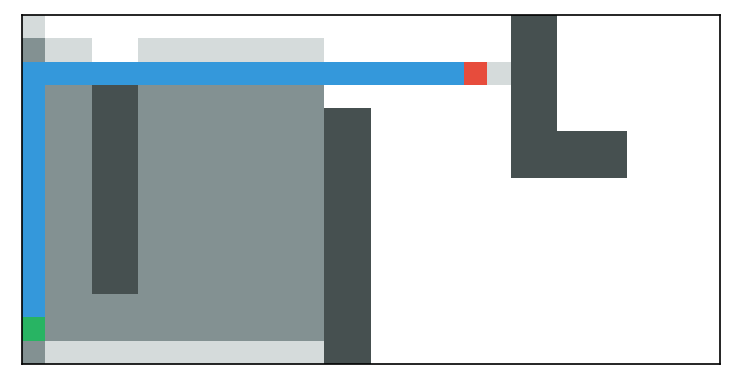

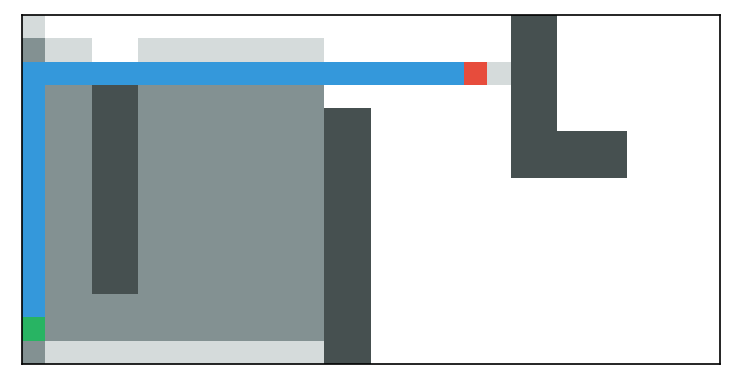

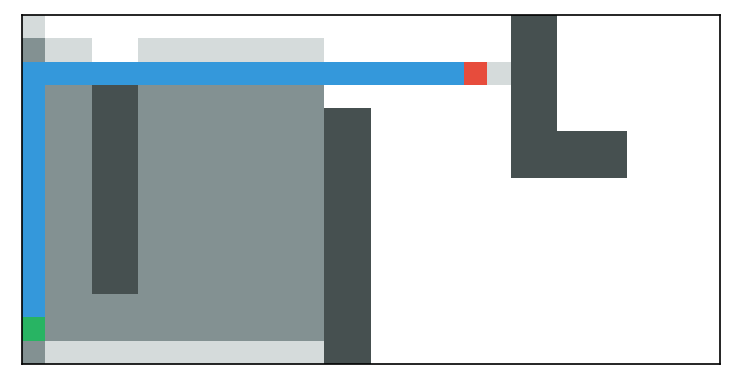

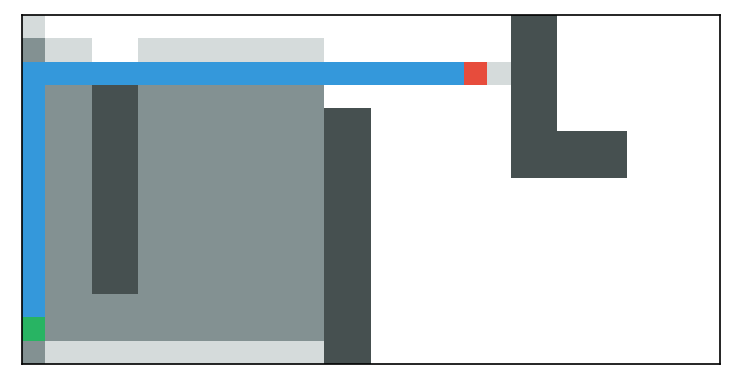

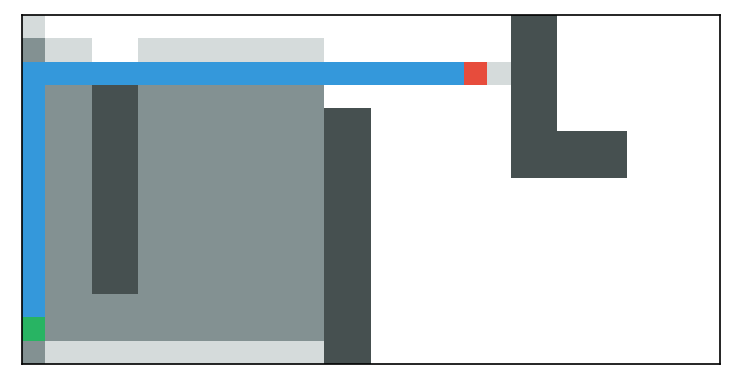

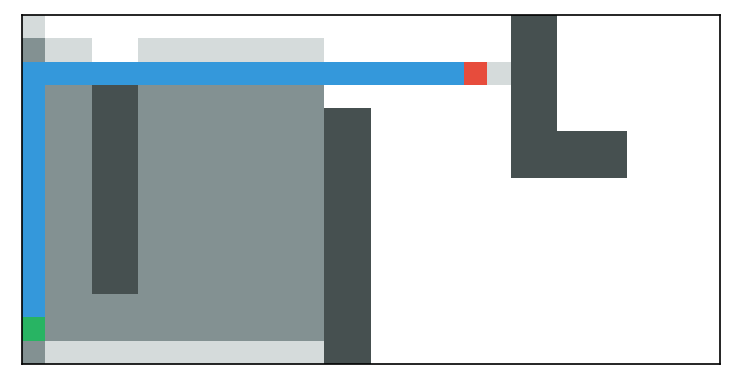

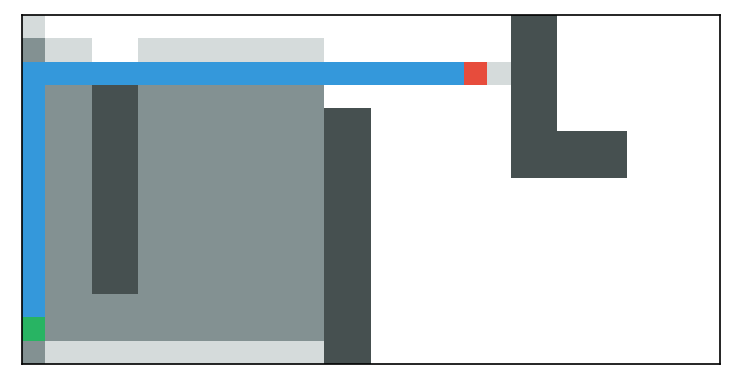

In [90]:
for i in range(25):
  %time SimpleTest(WAStar, 1, ManhattanDistance, OpenList, ClosedList, False, 1.0)

Path found! Length: 39.31370849898476. Nodes created: 4055. Number of steps: 3920. Correct: True
CPU times: user 359 ms, sys: 1.96 ms, total: 361 ms
Wall time: 364 ms
Path found! Length: 31.313708498984763. Nodes created: 3160. Number of steps: 3072. Correct: True
CPU times: user 291 ms, sys: 3 ms, total: 294 ms
Wall time: 297 ms
Path found! Length: 33.39949493661167. Nodes created: 4203. Number of steps: 4045. Correct: True
CPU times: user 511 ms, sys: 4.96 ms, total: 516 ms
Wall time: 518 ms
Path found! Length: 21.72792206135786. Nodes created: 2439. Number of steps: 2186. Correct: True
CPU times: user 254 ms, sys: 1.01 ms, total: 255 ms
Wall time: 255 ms
Path found! Length: 31.485281374238575. Nodes created: 3833. Number of steps: 3721. Correct: True
CPU times: user 382 ms, sys: 3 ms, total: 385 ms
Wall time: 385 ms
Path found! Length: 27.656854249492383. Nodes created: 4657. Number of steps: 4391. Correct: True
CPU times: user 602 ms, sys: 3.03 ms, total: 605 ms
Wall time: 604 ms
P

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 36.627416997969526. Nodes created: 4891. Number of steps: 4678. Correct: True
CPU times: user 483 ms, sys: 1.01 ms, total: 484 ms
Wall time: 489 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 30.89949493661167. Nodes created: 3928. Number of steps: 3814. Correct: True
CPU times: user 412 ms, sys: 0 ns, total: 412 ms
Wall time: 414 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 33.97056274847715. Nodes created: 5162. Number of steps: 4966. Correct: True
CPU times: user 562 ms, sys: 2.92 ms, total: 565 ms
Wall time: 565 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 45.970562748477136. Nodes created: 5778. Number of steps: 5683. Correct: True
CPU times: user 538 ms, sys: 5 ms, total: 543 ms
Wall time: 545 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 47.79898987322333. Nodes created: 5870. Number of steps: 5776. Correct: True
CPU times: user 572 ms, sys: 3.02 ms, total: 575 ms
Wall time: 576 ms


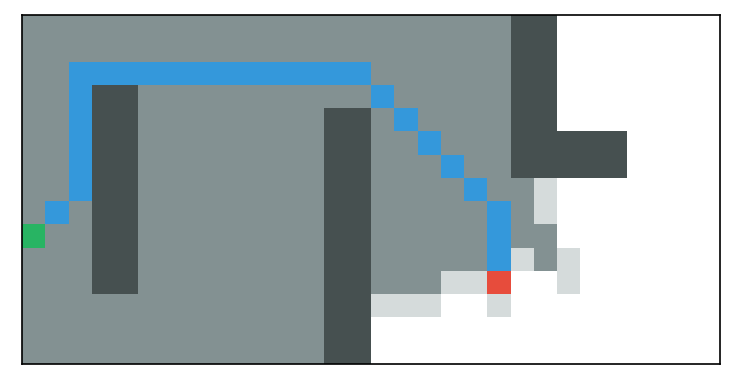

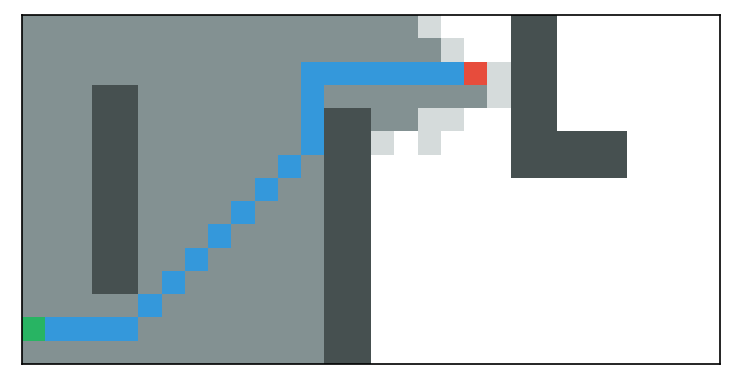

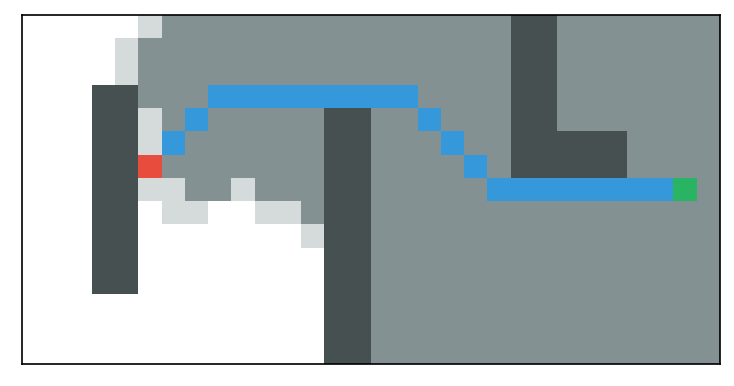

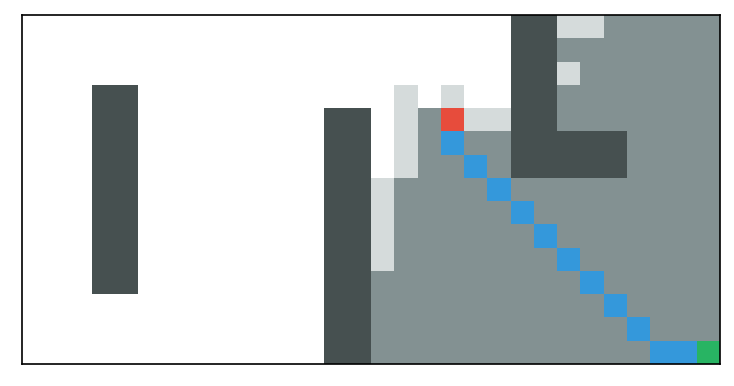

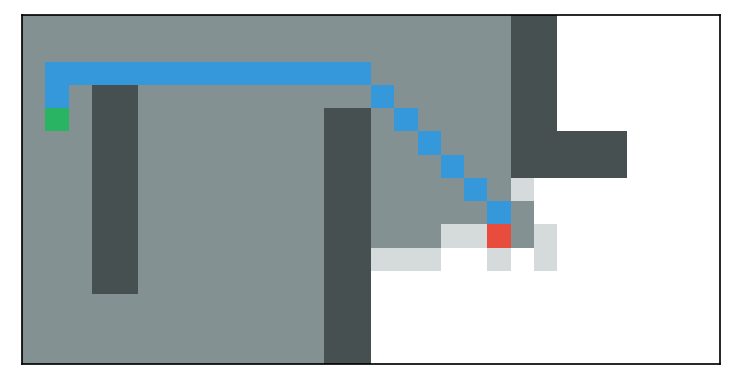

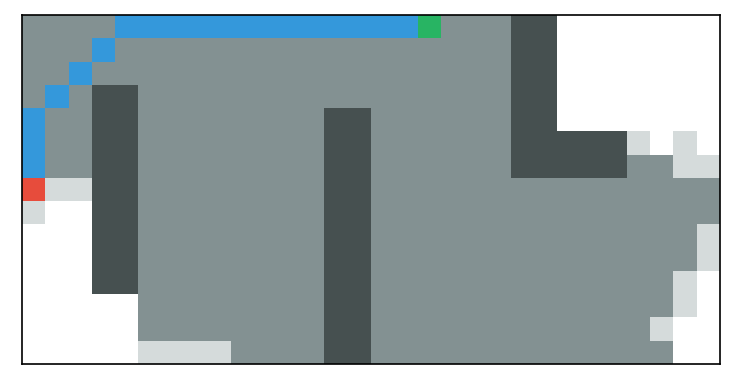

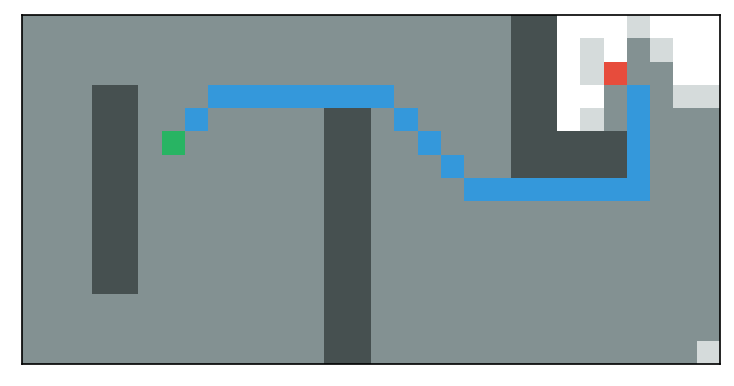

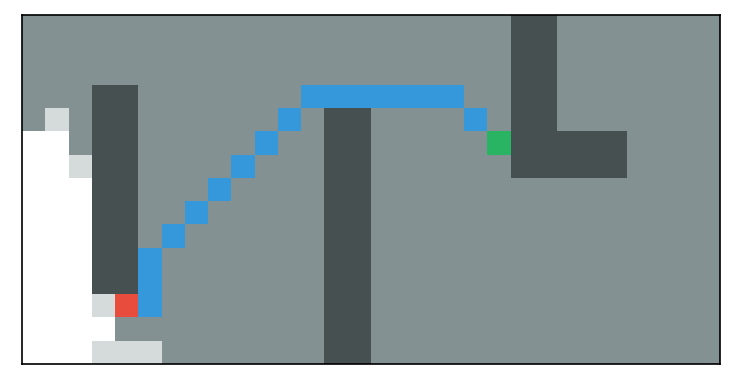

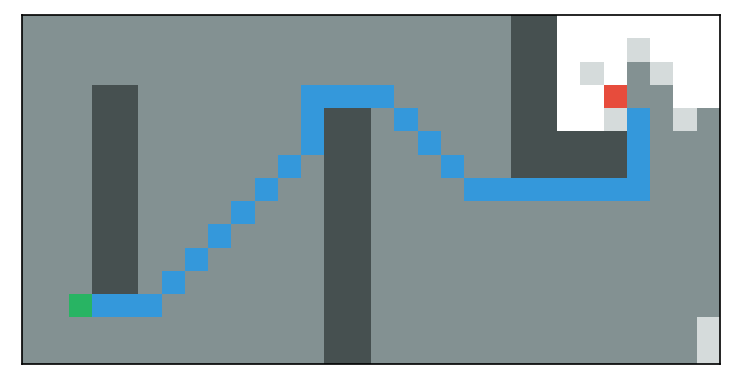

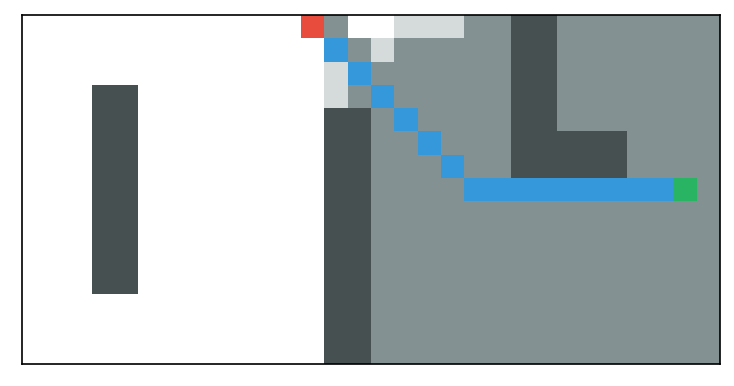

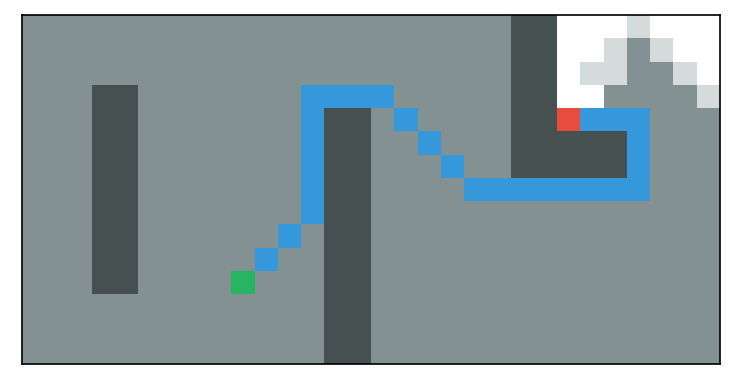

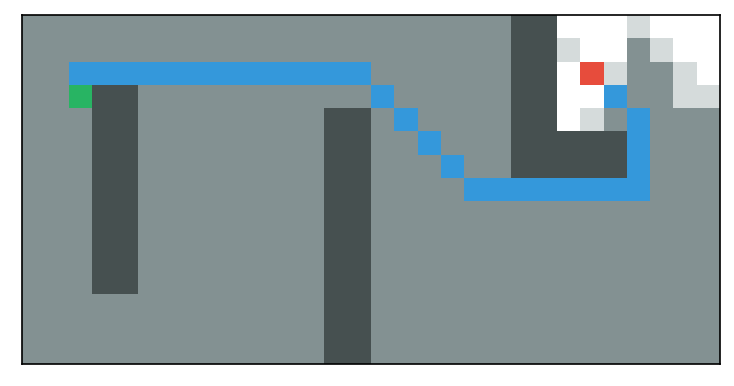

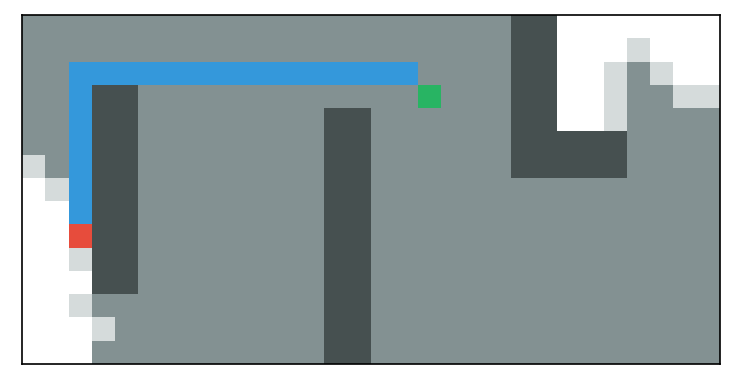

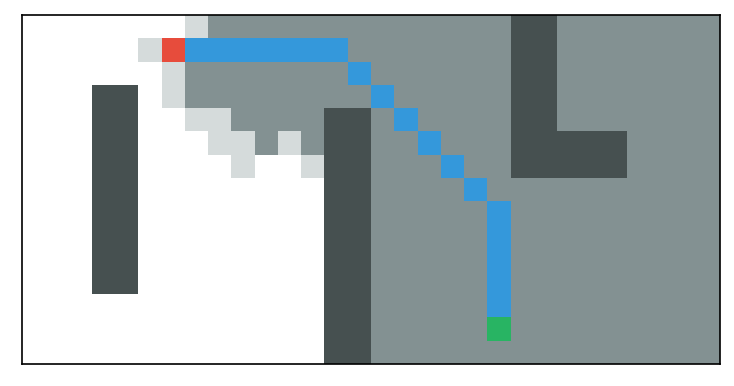

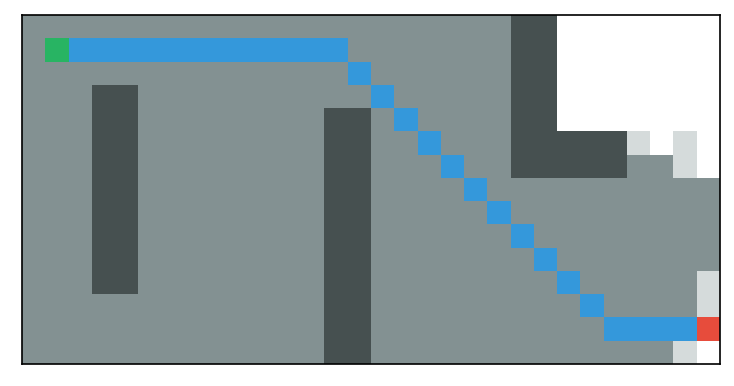

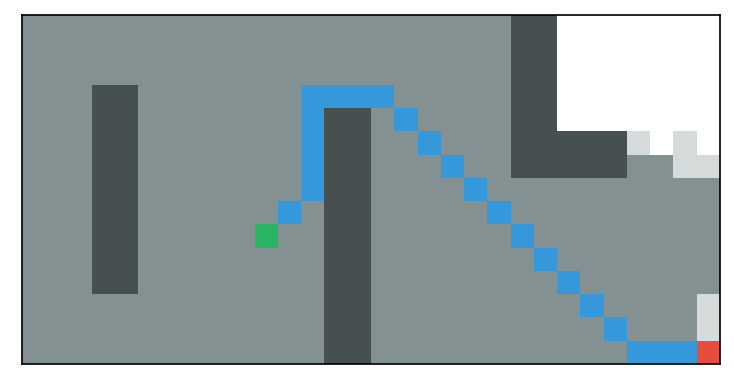

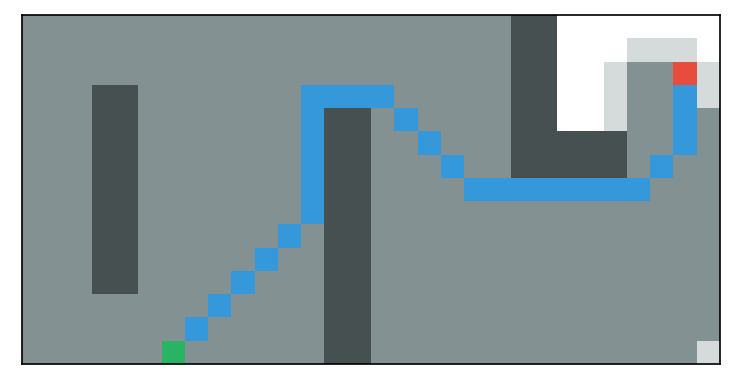

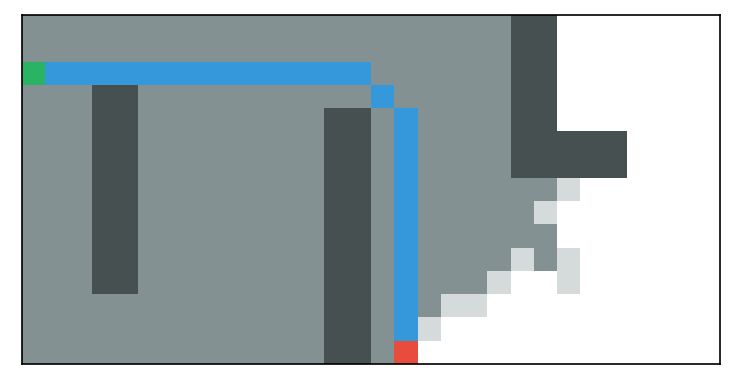

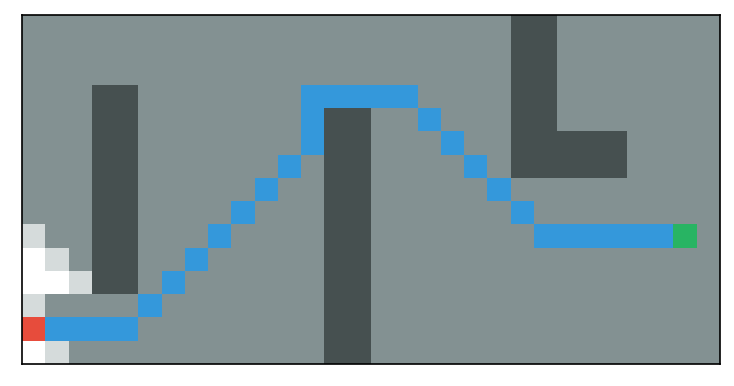

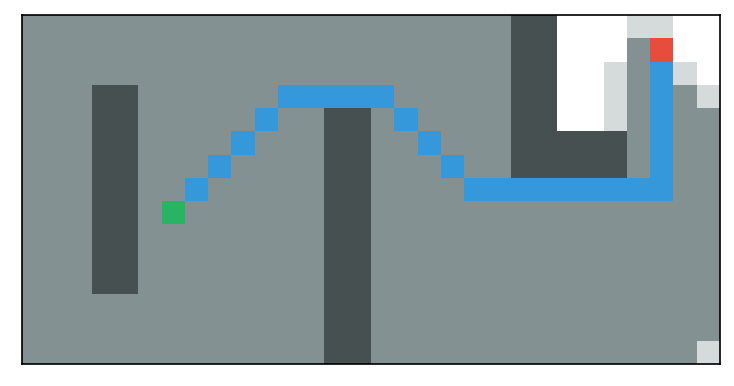

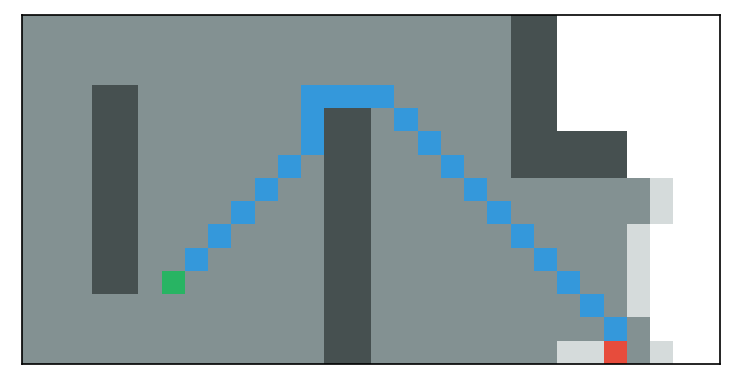

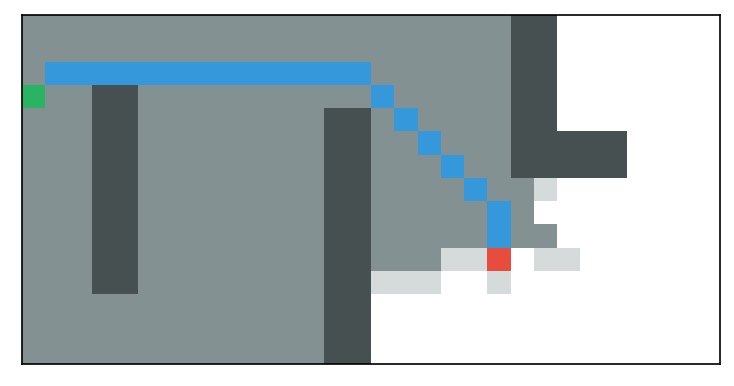

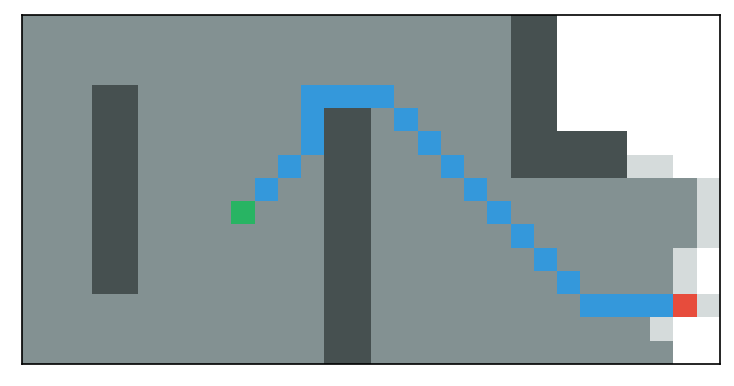

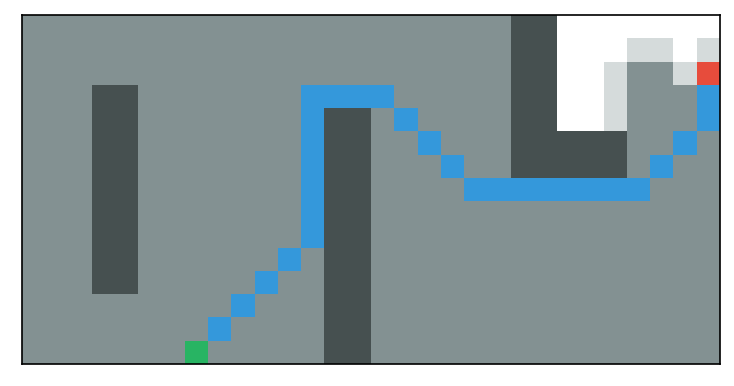

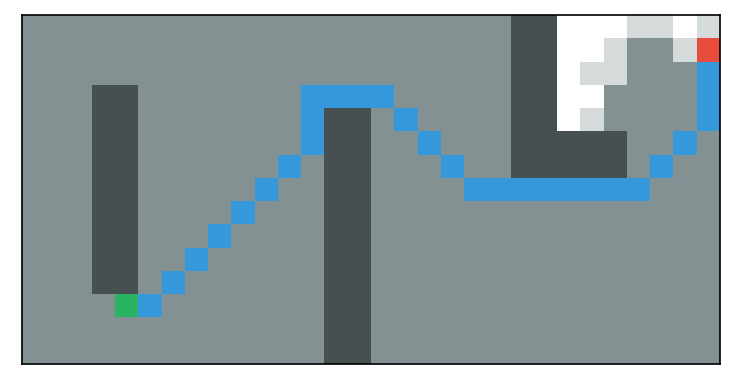

In [91]:
for i in range(25):
  %time SimpleTest(WAStar, i, DiagonalDistance, OpenList,YourClosed, True, 1.0)

Path found! Length: 39.31370849898476. Nodes created: 4017. Number of steps: 3884. Correct: True
CPU times: user 363 ms, sys: 4.01 ms, total: 367 ms
Wall time: 368 ms
Path found! Length: 31.313708498984763. Nodes created: 3128. Number of steps: 3059. Correct: True
CPU times: user 289 ms, sys: 967 µs, total: 290 ms
Wall time: 291 ms
Path found! Length: 33.39949493661167. Nodes created: 4167. Number of steps: 4005. Correct: True
CPU times: user 446 ms, sys: 3.05 ms, total: 449 ms
Wall time: 452 ms
Path found! Length: 21.72792206135786. Nodes created: 2368. Number of steps: 2115. Correct: True
CPU times: user 252 ms, sys: 2.02 ms, total: 254 ms
Wall time: 255 ms
Path found! Length: 31.485281374238575. Nodes created: 3804. Number of steps: 3684. Correct: True
CPU times: user 403 ms, sys: 3.01 ms, total: 406 ms
Wall time: 407 ms
Path found! Length: 27.656854249492383. Nodes created: 4522. Number of steps: 4276. Correct: True
CPU times: user 590 ms, sys: 5.01 ms, total: 595 ms
Wall time: 595

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 36.627416997969526. Nodes created: 4832. Number of steps: 4621. Correct: True
CPU times: user 461 ms, sys: 1.99 ms, total: 463 ms
Wall time: 463 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 30.89949493661167. Nodes created: 3904. Number of steps: 3789. Correct: True
CPU times: user 414 ms, sys: 5.02 ms, total: 419 ms
Wall time: 420 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 33.97056274847715. Nodes created: 5102. Number of steps: 4902. Correct: True
CPU times: user 550 ms, sys: 4.04 ms, total: 554 ms
Wall time: 554 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 45.970562748477136. Nodes created: 5757. Number of steps: 5655. Correct: True
CPU times: user 562 ms, sys: 6.96 ms, total: 569 ms
Wall time: 571 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 47.79898987322333. Nodes created: 5843. Number of steps: 5746. Correct: True
CPU times: user 566 ms, sys: 995 µs, total: 567 ms
Wall time: 566 ms


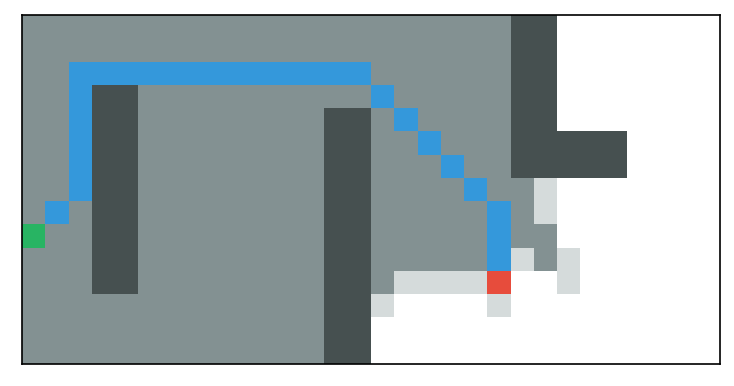

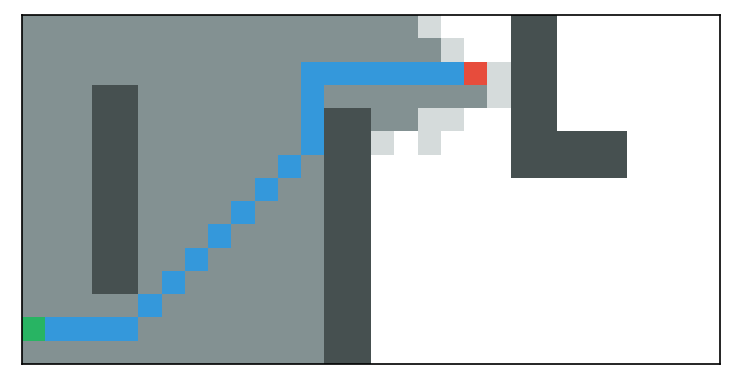

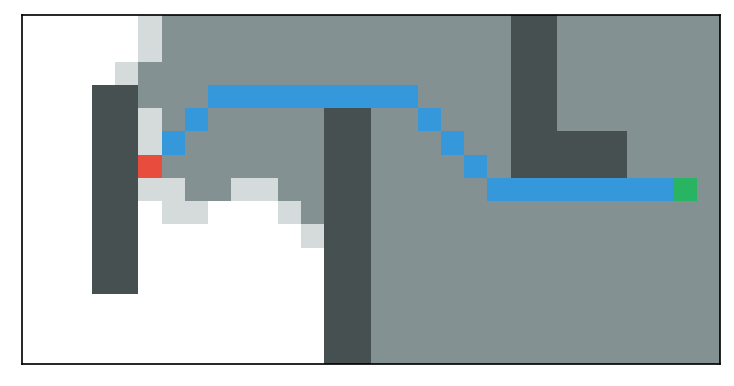

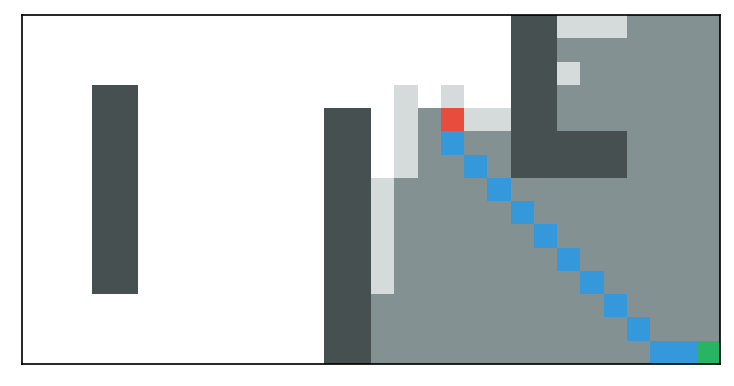

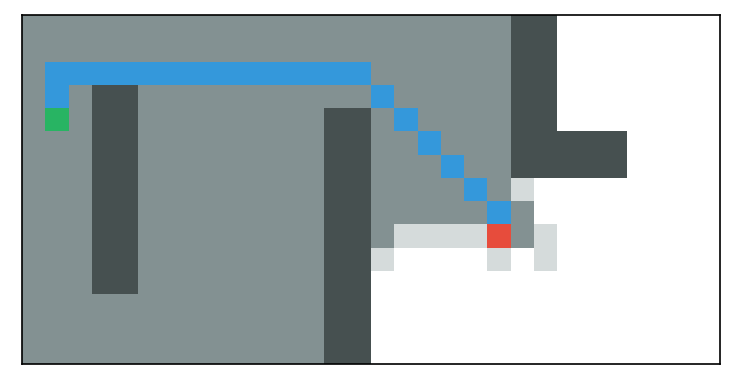

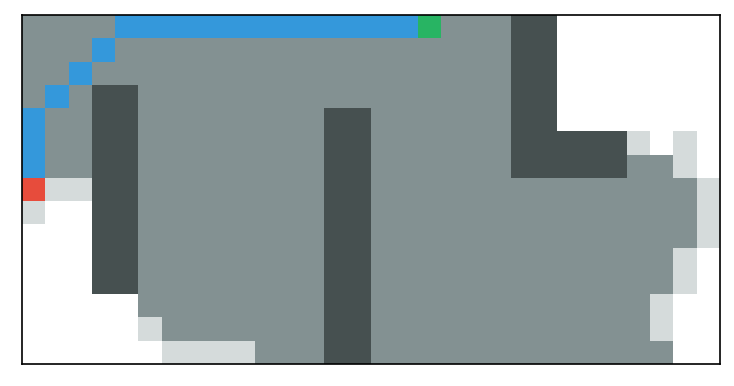

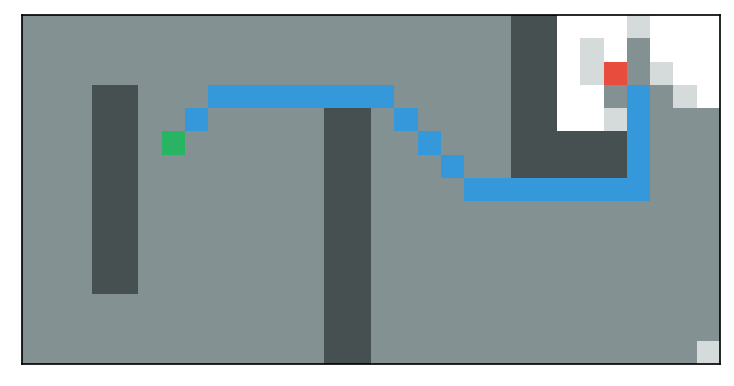

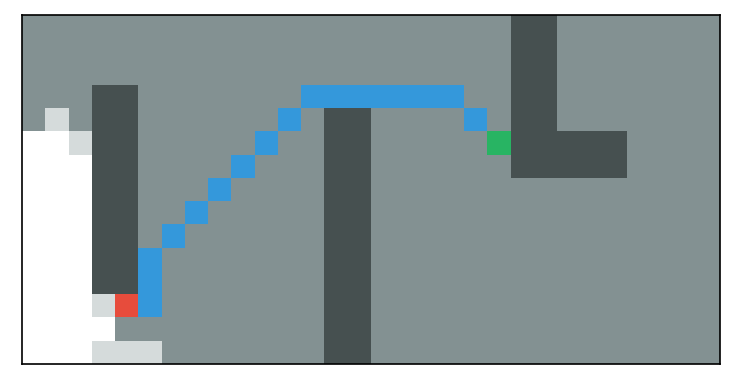

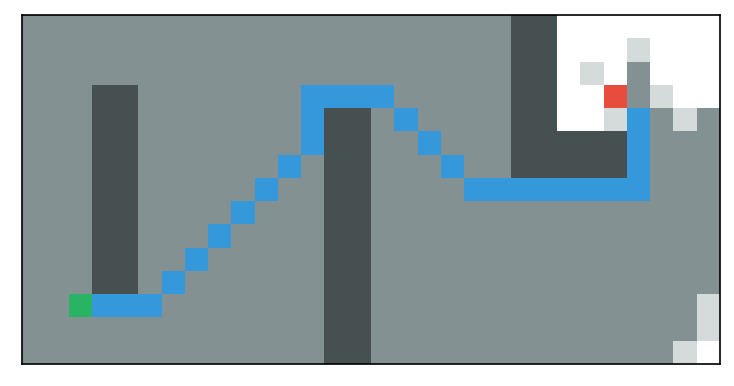

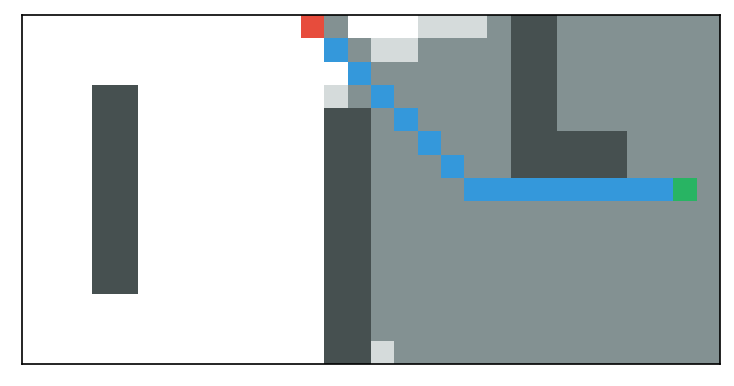

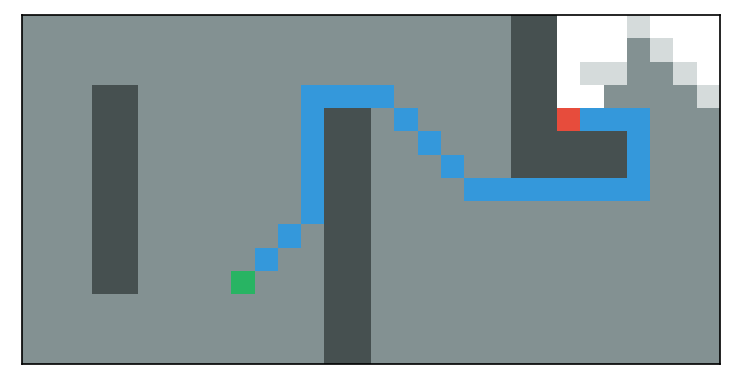

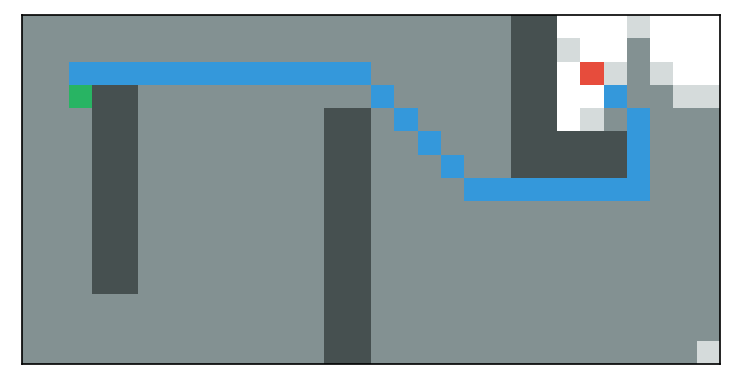

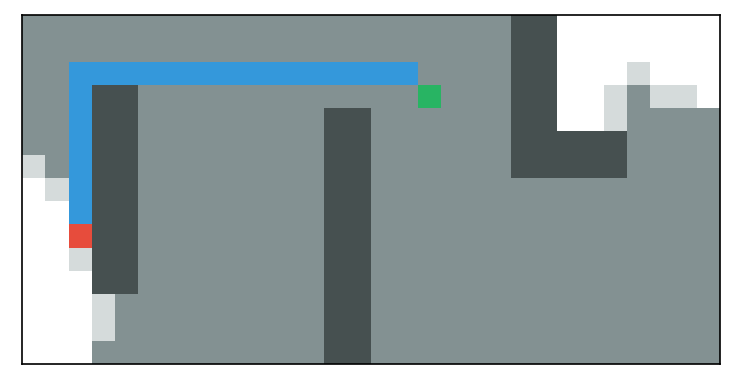

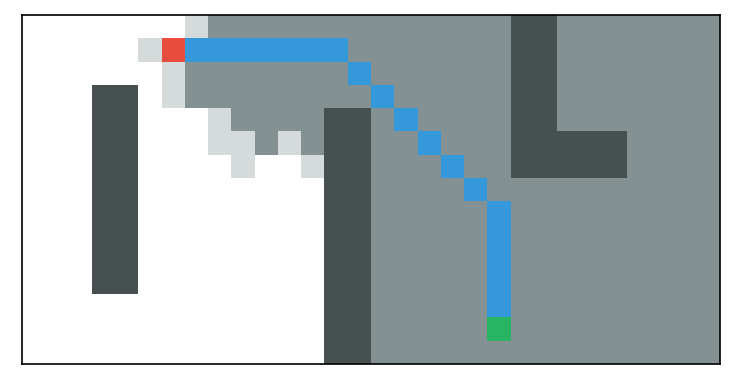

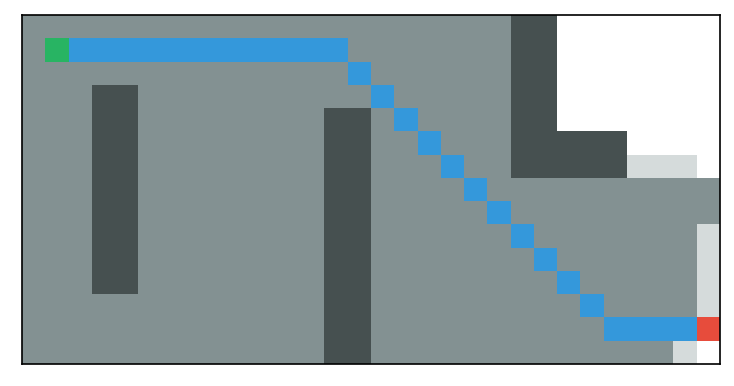

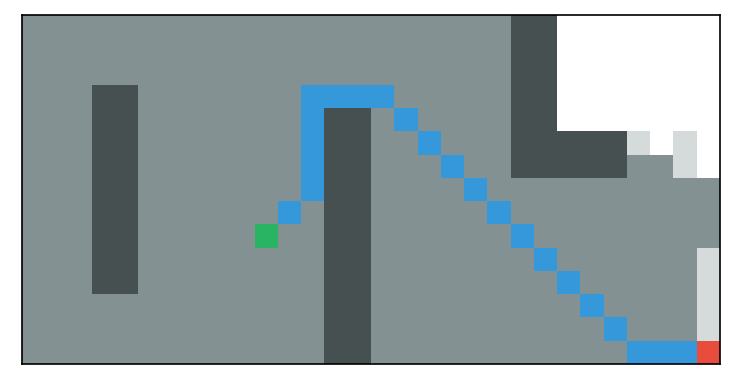

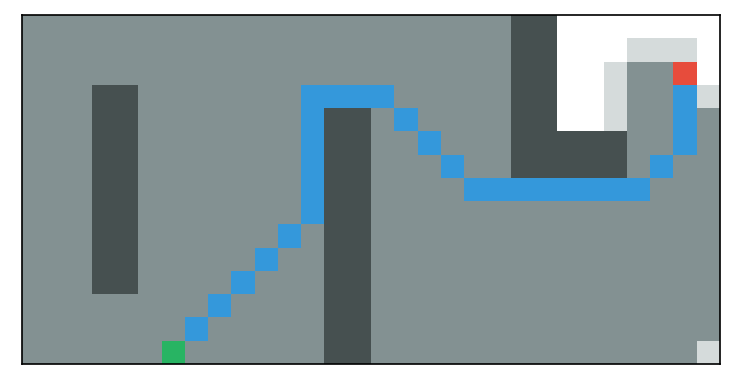

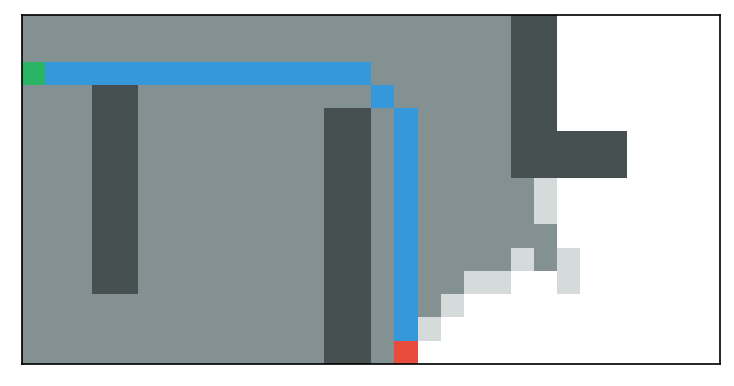

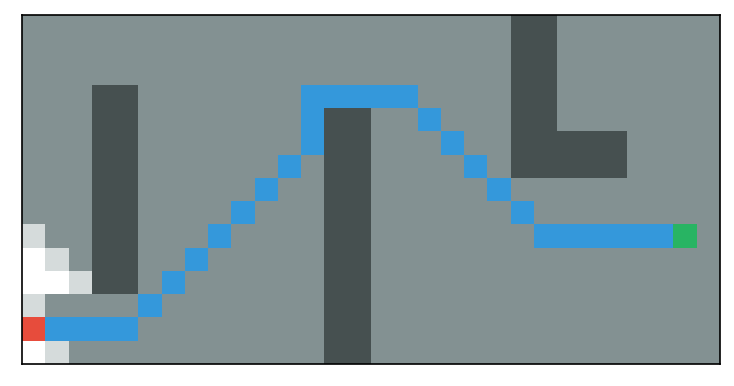

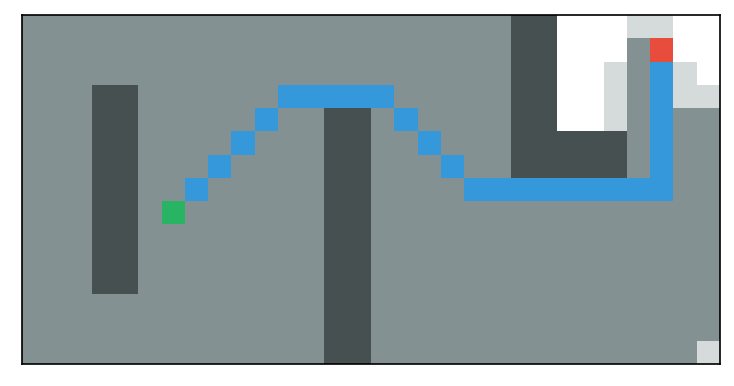

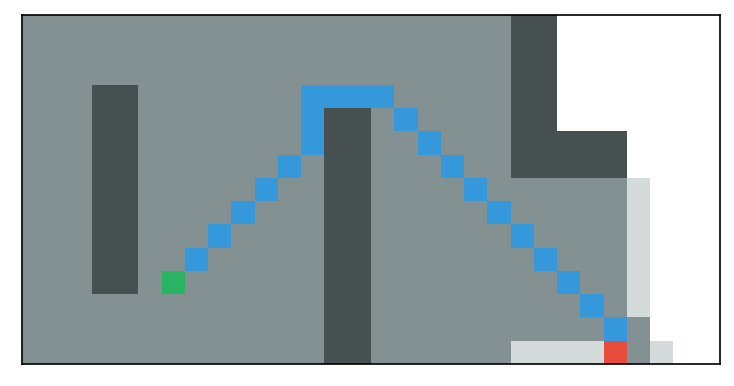

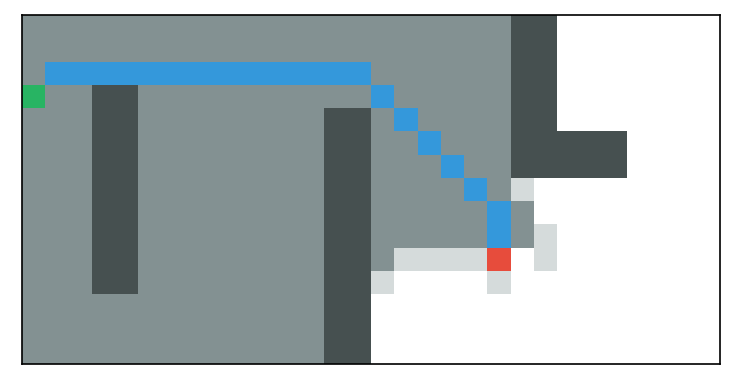

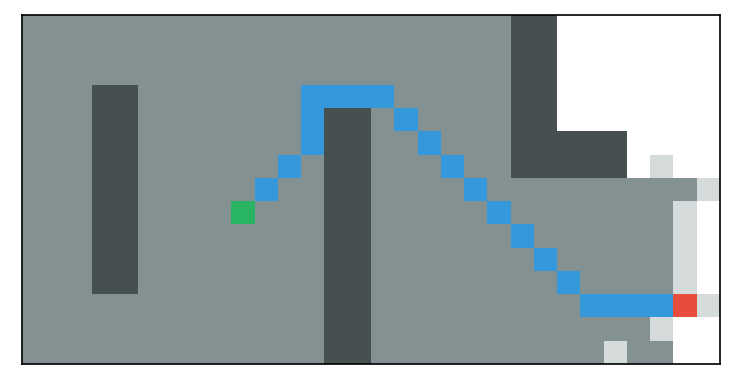

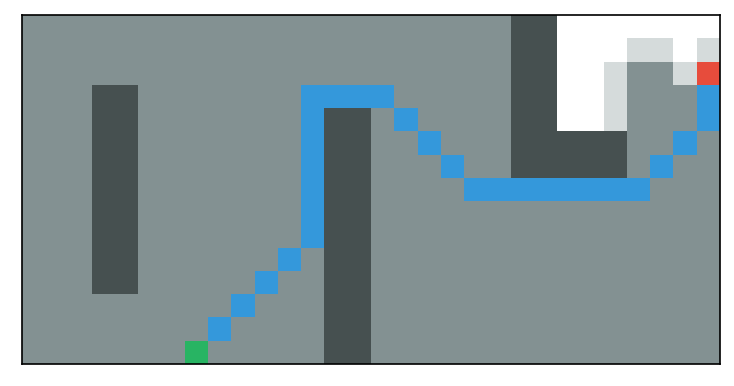

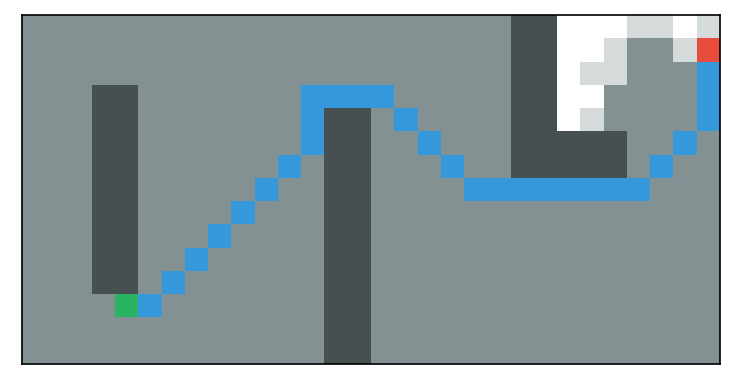

In [92]:
for i in range(25):
  %time SimpleTest(WAStar, i, DiagonalDistance, OpenList,YourClosed, True, 1.1)

Path found! Length: 39.31370849898476. Nodes created: 3824. Number of steps: 3682. Correct: True
CPU times: user 360 ms, sys: 2.02 ms, total: 362 ms
Wall time: 363 ms
Path found! Length: 31.313708498984763. Nodes created: 3033. Number of steps: 2937. Correct: True
CPU times: user 315 ms, sys: 3.98 ms, total: 319 ms
Wall time: 321 ms
Path found! Length: 33.39949493661167. Nodes created: 3897. Number of steps: 3747. Correct: True
CPU times: user 422 ms, sys: 4.97 ms, total: 427 ms
Wall time: 427 ms
Path found! Length: 21.72792206135786. Nodes created: 1881. Number of steps: 1687. Correct: True
CPU times: user 208 ms, sys: 1.99 ms, total: 210 ms
Wall time: 210 ms
Path found! Length: 31.485281374238575. Nodes created: 3612. Number of steps: 3434. Correct: True
CPU times: user 423 ms, sys: 2.99 ms, total: 426 ms
Wall time: 426 ms
Path found! Length: 27.656854249492383. Nodes created: 3687. Number of steps: 3423. Correct: True
CPU times: user 455 ms, sys: 1 ms, total: 456 ms
Wall time: 456 m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 36.627416997969526. Nodes created: 4425. Number of steps: 4227. Correct: True
CPU times: user 435 ms, sys: 1.01 ms, total: 436 ms
Wall time: 434 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 30.89949493661167. Nodes created: 3691. Number of steps: 3482. Correct: True
CPU times: user 436 ms, sys: 2.99 ms, total: 439 ms
Wall time: 438 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 33.97056274847715. Nodes created: 4685. Number of steps: 4440. Correct: True
CPU times: user 522 ms, sys: 1.02 ms, total: 523 ms
Wall time: 520 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 45.970562748477136. Nodes created: 5493. Number of steps: 5293. Correct: True
CPU times: user 554 ms, sys: 4 ms, total: 558 ms
Wall time: 557 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length: 47.79898987322333. Nodes created: 5621. Number of steps: 5452. Correct: True
CPU times: user 563 ms, sys: 2 ms, total: 565 ms
Wall time: 566 ms


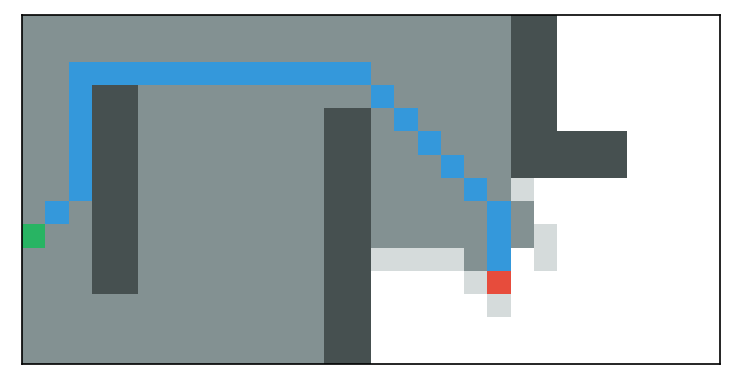

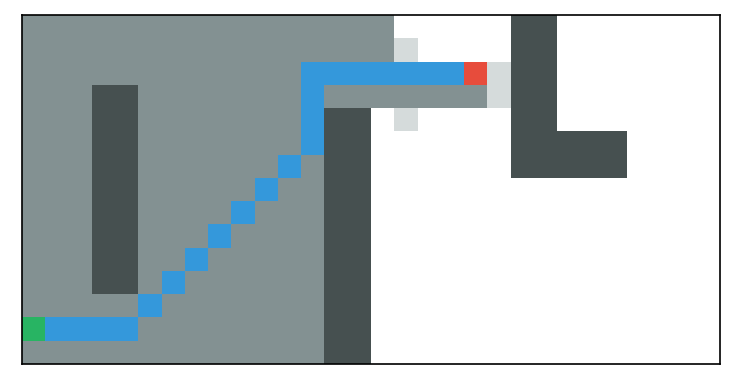

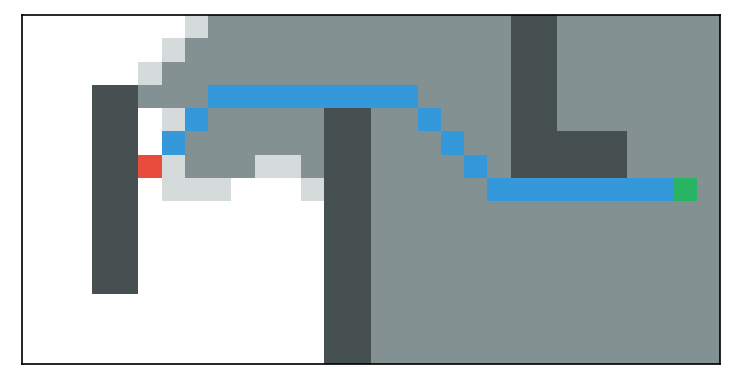

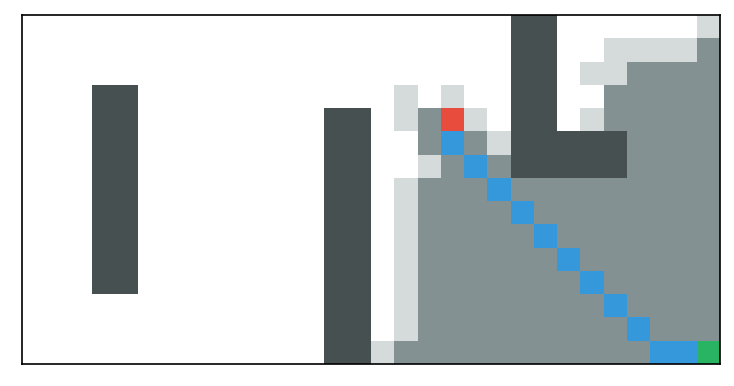

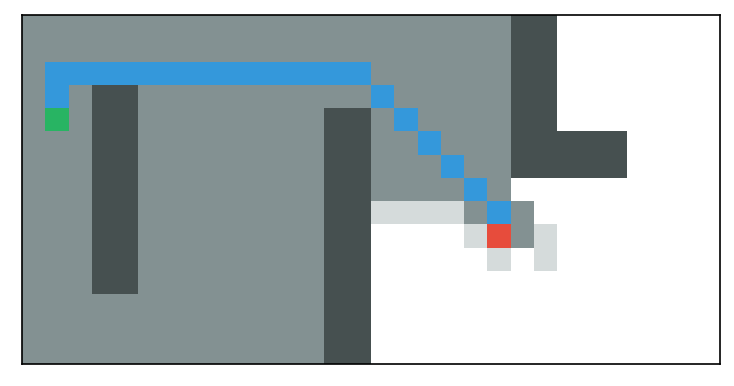

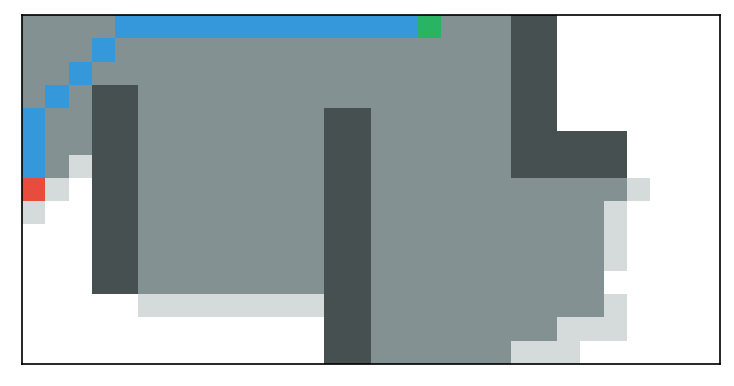

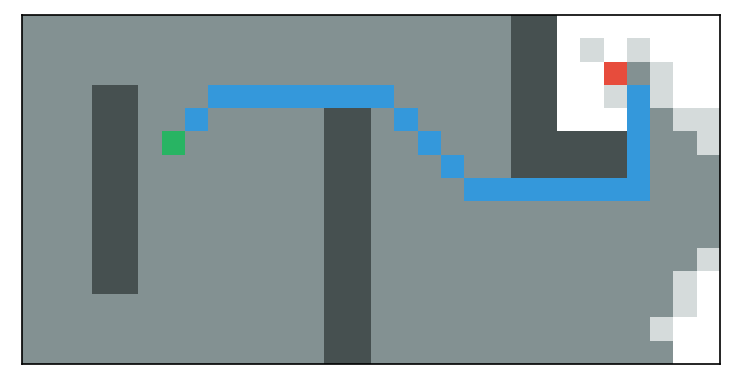

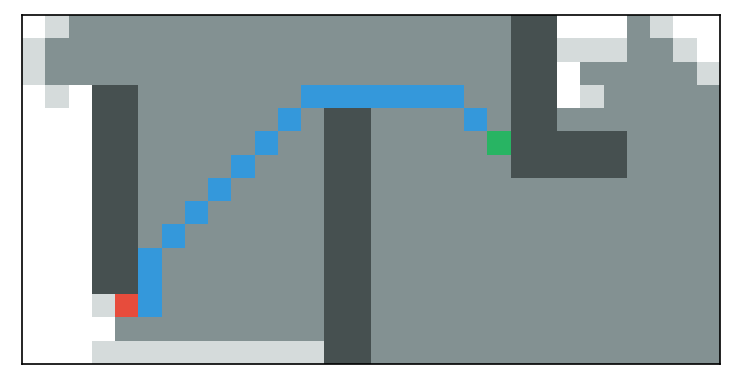

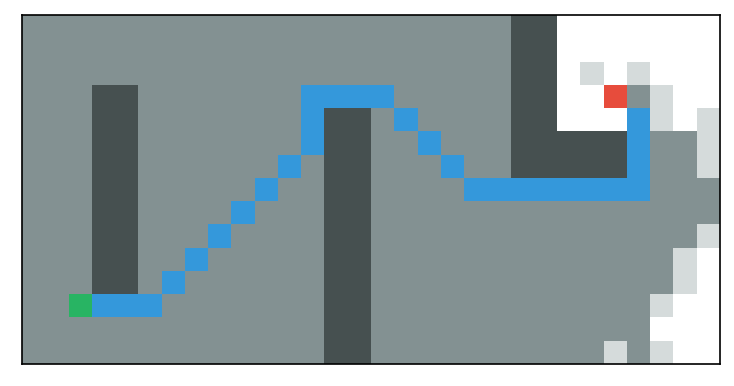

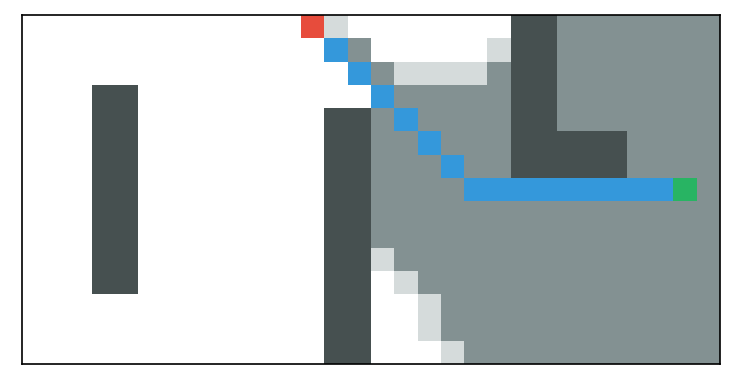

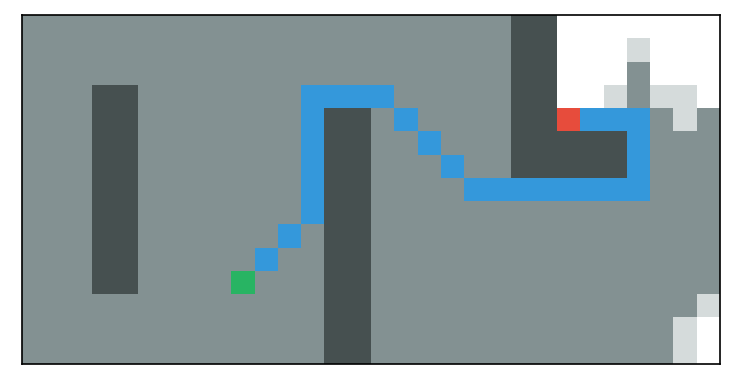

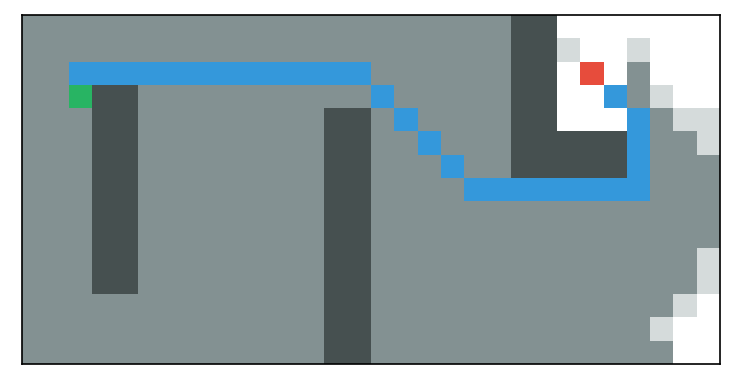

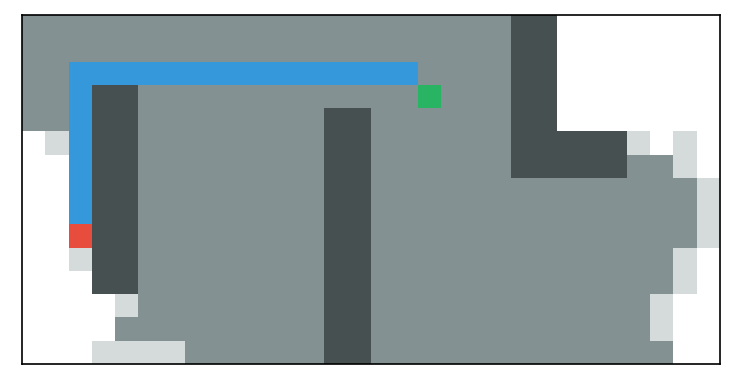

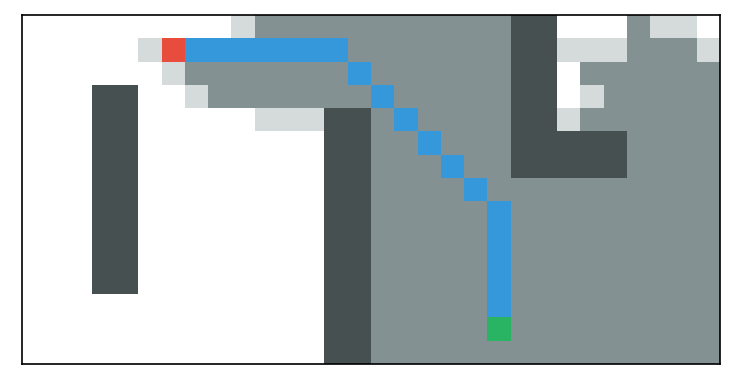

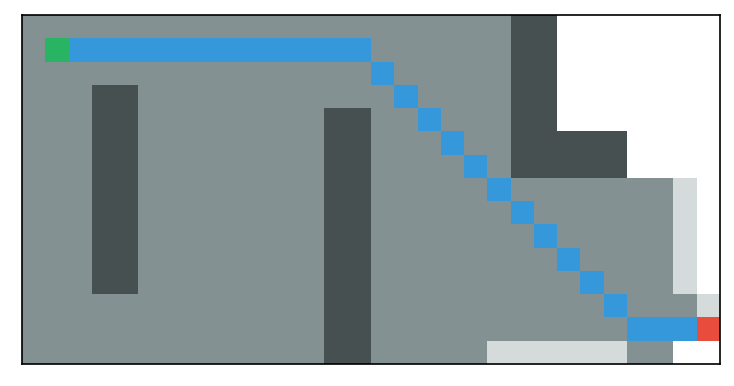

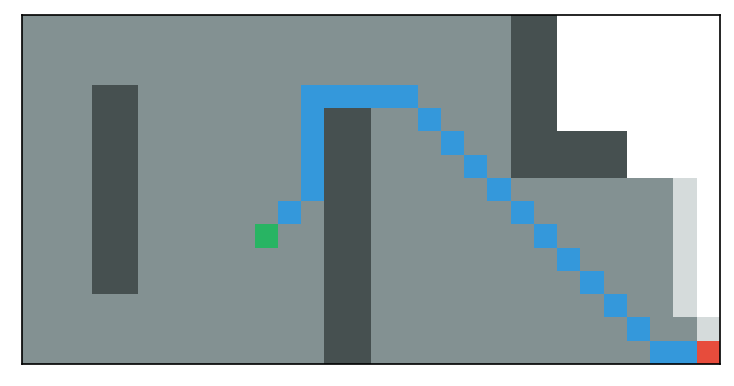

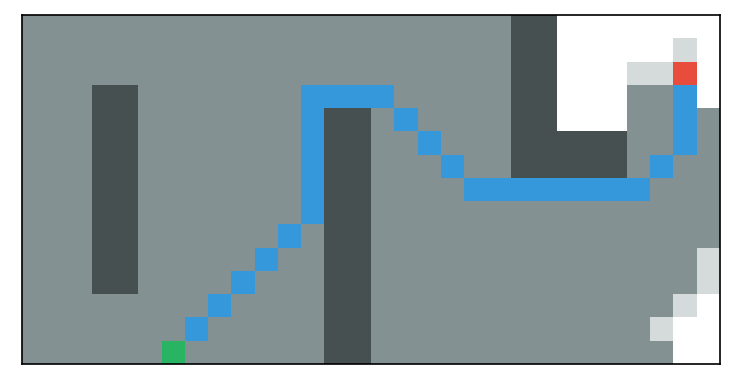

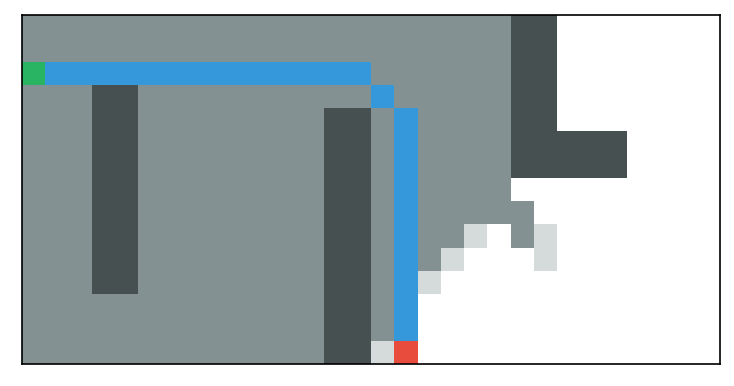

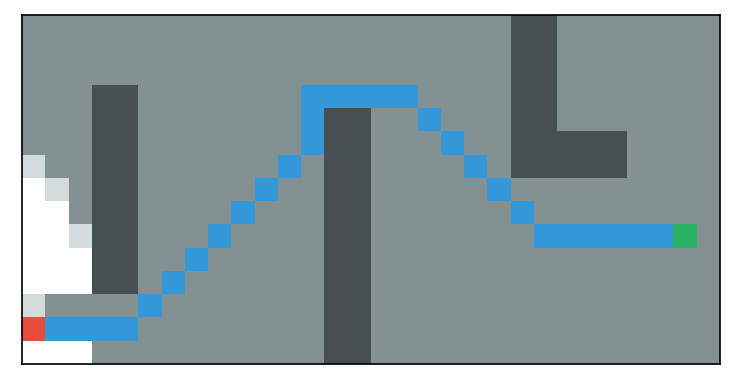

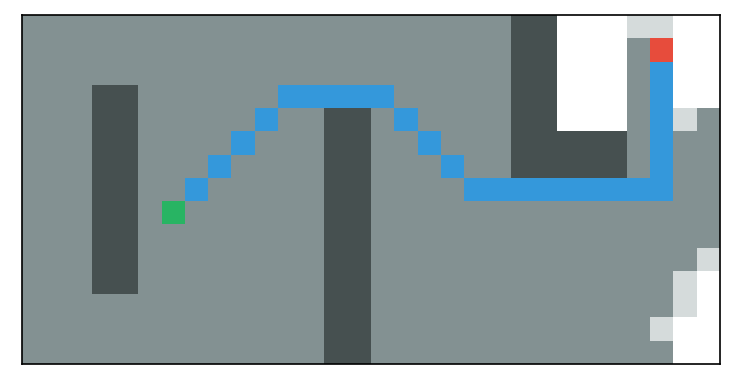

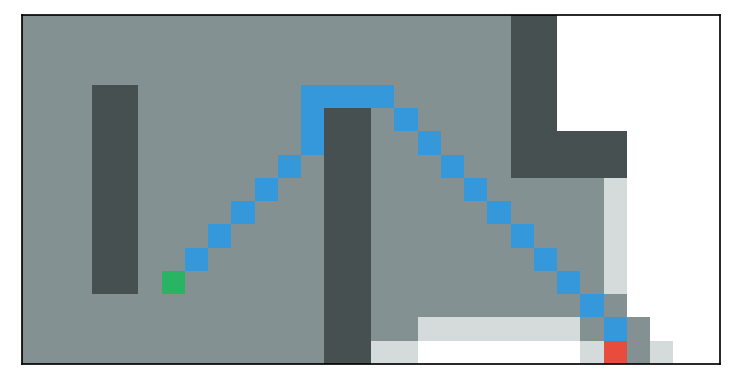

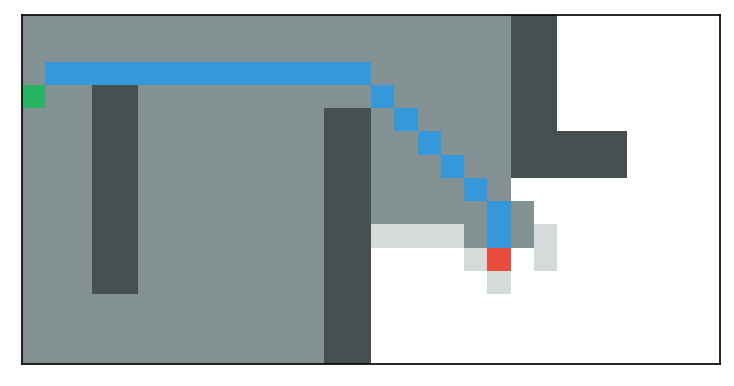

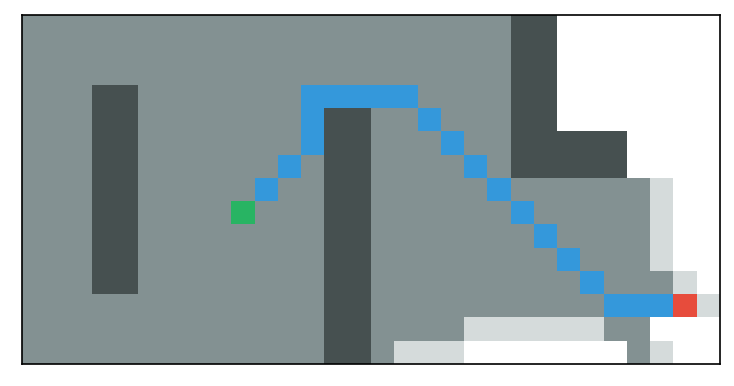

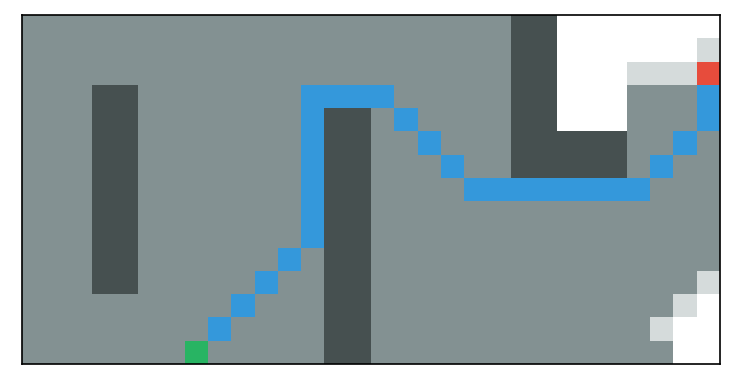

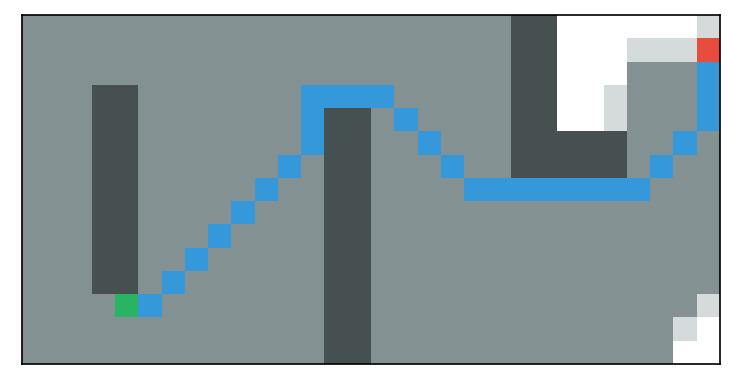

In [93]:
for i in range(25):
  %time SimpleTest(WAStar, i, DiagonalDistance, OpenList,YourClosed, True, 2.0)

In [94]:
#running massive test of optimal A* on 4-connected grids with Manhattan-distance heuristic
%time astCardStat = MassiveTest(WAStar, ManhattanDistance, YourOpen,YourClosed, False, 1.0)

Path found! Length: 67.0. Nodes created: 4388. Number of steps: 1902. Correct: True
Path found! Length: 214.0. Nodes created: 32017. Number of steps: 31165. Correct: True
Path found! Length: 480.0. Nodes created: 203366. Number of steps: 192953. Correct: True
Path found! Length: 568.0. Nodes created: 262175. Number of steps: 260825. Correct: True
Path found! Length: 507.0. Nodes created: 234237. Number of steps: 231369. Correct: True
Path found! Length: 418.0. Nodes created: 97283. Number of steps: 92763. Correct: True
Path found! Length: 769.0. Nodes created: 666321. Number of steps: 664050. Correct: True
Path found! Length: 702.0. Nodes created: 434638. Number of steps: 430702. Correct: True
Path found! Length: 692.0. Nodes created: 414126. Number of steps: 380667. Correct: True
CPU times: user 3min 56s, sys: 1.88 s, total: 3min 58s
Wall time: 4min


In [95]:
#running massive test of optimal A* on 8-connected grids with Diagonal-distance heuristic
%time astDiagStat = MassiveTest(WAStar, DiagonalDistance, YourOpen,YourClosed, True, 1.0)

Path found! Length: 52.183766184073555. Nodes created: 23844. Number of steps: 22918. Correct: True
Path found! Length: 204.02691193458136. Nodes created: 118632. Number of steps: 118402. Correct: True
Path found! Length: 376.94574285495037. Nodes created: 734158. Number of steps: 733997. Correct: True
Path found! Length: 441.4163056034276. Nodes created: 710455. Number of steps: 710260. Correct: True
Path found! Length: 373.04119728445545. Nodes created: 760367. Number of steps: 760187. Correct: True
Path found! Length: 359.59292911256387. Nodes created: 450149. Number of steps: 449860. Correct: True
Path found! Length: 591.1808075912456. Nodes created: 1819914. Number of steps: 1819169. Correct: True
Path found! Length: 553.7396820942909. Nodes created: 1235660. Number of steps: 1234544. Correct: True
Path found! Length: 599.2741699796965. Nodes created: 1535157. Number of steps: 1534771. Correct: True
CPU times: user 11min 19s, sys: 4.32 s, total: 11min 23s
Wall time: 11min 24s


In [96]:
#running massive test of optimal A* on 8-connected grids with Euclidean-distance heuristic
%time astEuclidStat = MassiveTest(WAStar, EuclideanDistance, YourOpen, YourClosed, True, 1.0)

Path found! Length: 52.183766184073555. Nodes created: 6795. Number of steps: 4804. Correct: True
Path found! Length: 204.02691193458136. Nodes created: 89961. Number of steps: 88472. Correct: True
Path found! Length: 376.94574285495037. Nodes created: 369379. Number of steps: 358054. Correct: True
Path found! Length: 441.4163056034276. Nodes created: 451741. Number of steps: 448544. Correct: True
Path found! Length: 373.04119728445545. Nodes created: 297492. Number of steps: 289641. Correct: True
Path found! Length: 359.59292911256387. Nodes created: 269278. Number of steps: 263533. Correct: True
Path found! Length: 591.1808075912456. Nodes created: 1178956. Number of steps: 1174896. Correct: True
Path found! Length: 553.7396820942909. Nodes created: 652137. Number of steps: 641669. Correct: True
Path found! Length: 599.2741699796965. Nodes created: 927945. Number of steps: 914155. Correct: True
CPU times: user 12min 12s, sys: 2.74 s, total: 12min 14s
Wall time: 12min 15s


In [97]:
#running massive test of weighted A* on 8-connected grids with Diagonal-distance heuristic and hweight = 1.01
%time wastDiagStat101 = MassiveTest(WAStar, DiagonalDistance, YourOpen, YourClosed, True, 1.01)

Path found! Length: 52.183766184073555. Nodes created: 23784. Number of steps: 22874. Correct: True
Path found! Length: 204.02691193458136. Nodes created: 118624. Number of steps: 118388. Correct: True
Path found! Length: 376.94574285495037. Nodes created: 734147. Number of steps: 733988. Correct: True
Path found! Length: 441.4163056034276. Nodes created: 710443. Number of steps: 710248. Correct: True
Path found! Length: 373.04119728445545. Nodes created: 760354. Number of steps: 760175. Correct: True
Path found! Length: 359.59292911256387. Nodes created: 450133. Number of steps: 449842. Correct: True
Path found! Length: 591.1808075912456. Nodes created: 1819790. Number of steps: 1819044. Correct: True
Path found! Length: 553.7396820942909. Nodes created: 1235539. Number of steps: 1234424. Correct: True
Path found! Length: 599.2741699796965. Nodes created: 1535134. Number of steps: 1534750. Correct: True
CPU times: user 11min 30s, sys: 3.6 s, total: 11min 33s
Wall time: 11min 34s


In [98]:
#running massive test of weighted A* on 8-connected grids with Diagonal-distance heuristic and hweight = 1.1
%time wastDiagStat11 = MassiveTest(WAStar, DiagonalDistance, YourOpen, YourClosed, True, 1.1)

Path found! Length: 52.183766184073555. Nodes created: 23393. Number of steps: 22449. Correct: True
Path found! Length: 204.02691193458136. Nodes created: 118552. Number of steps: 118308. Correct: True
Path found! Length: 376.94574285495037. Nodes created: 734118. Number of steps: 733959. Correct: True
Path found! Length: 441.4163056034276. Nodes created: 710378. Number of steps: 710180. Correct: True
Path found! Length: 373.04119728445545. Nodes created: 760322. Number of steps: 760126. Correct: True
Path found! Length: 359.59292911256387. Nodes created: 449956. Number of steps: 449636. Correct: True
Path found! Length: 591.1808075912456. Nodes created: 1818693. Number of steps: 1817943. Correct: True
Path found! Length: 553.7396820942909. Nodes created: 1234843. Number of steps: 1233592. Correct: True
Path found! Length: 599.2741699796965. Nodes created: 1534992. Number of steps: 1534589. Correct: True
CPU times: user 11min 23s, sys: 3.24 s, total: 11min 26s
Wall time: 11min 26s


In [99]:
#running massive test of weighted A* on 8-connected grids with Diagonal-distance heuristic and hweight = 2
%time wastDiagStat2 = MassiveTest(WAStar, DiagonalDistance, YourOpen, YourClosed, True, 2)

Path found! Length: 52.183766184073555. Nodes created: 19869. Number of steps: 18985. Correct: True
Path found! Length: 204.02691193458136. Nodes created: 117497. Number of steps: 117062. Correct: True
Path found! Length: 376.94574285495037. Nodes created: 732659. Number of steps: 732106. Correct: True
Path found! Length: 441.4163056034276. Nodes created: 709787. Number of steps: 709483. Correct: True
Path found! Length: 373.04119728445545. Nodes created: 759687. Number of steps: 759296. Correct: True
Path found! Length: 359.59292911256387. Nodes created: 445868. Number of steps: 445244. Correct: True
Path found! Length: 591.1808075912456. Nodes created: 1805256. Number of steps: 1804004. Correct: True
Path found! Length: 553.7396820942909. Nodes created: 1224991. Number of steps: 1223555. Correct: True
Path found! Length: 599.2741699796965. Nodes created: 1533501. Number of steps: 1532952. Correct: True
CPU times: user 11min 34s, sys: 2.97 s, total: 11min 37s
Wall time: 11min 38s


# Analysis of results
Lets compare the results of WA* with Diagonal-distance heuristic and different heuristic weights on 8-connected grids

Additionally you can compare the results on 4-connected grids or with other heuristic functions

![2](./Image/3.png)

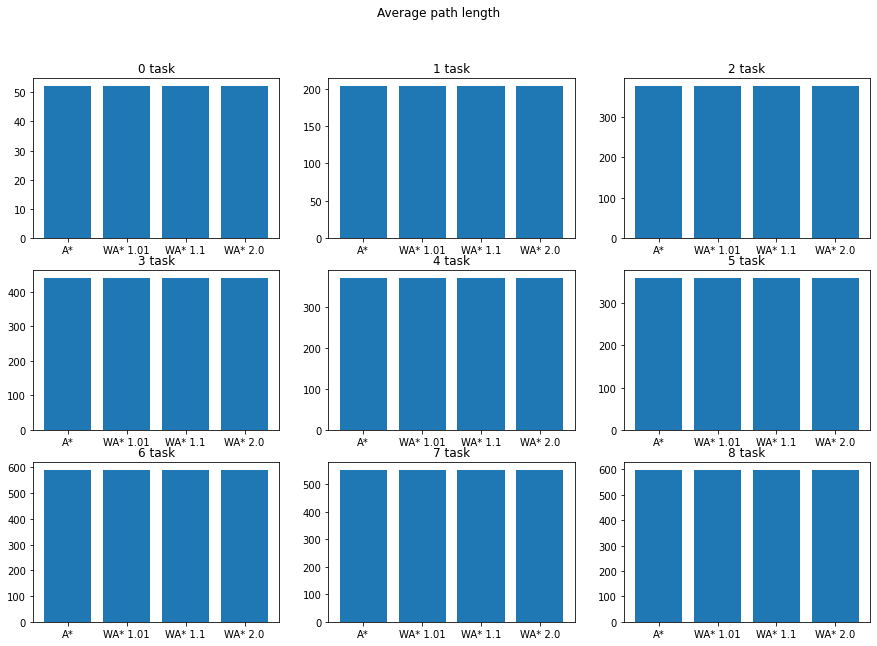

In [100]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
fig.suptitle('Average path length')
for i in range(9):
    ax = axs[i // 3, i % 3]
    ax.set_title(str(i) + " task")
    alg = ['A*', 'WA* 1.01', 'WA* 1.1', 'WA* 2.0' ]
    lens = [astDiagStat['len'][i], wastDiagStat101['len'][i], wastDiagStat11['len'][i], wastDiagStat2['len'][i]]
    ax.bar(alg, lens)
plt.show()

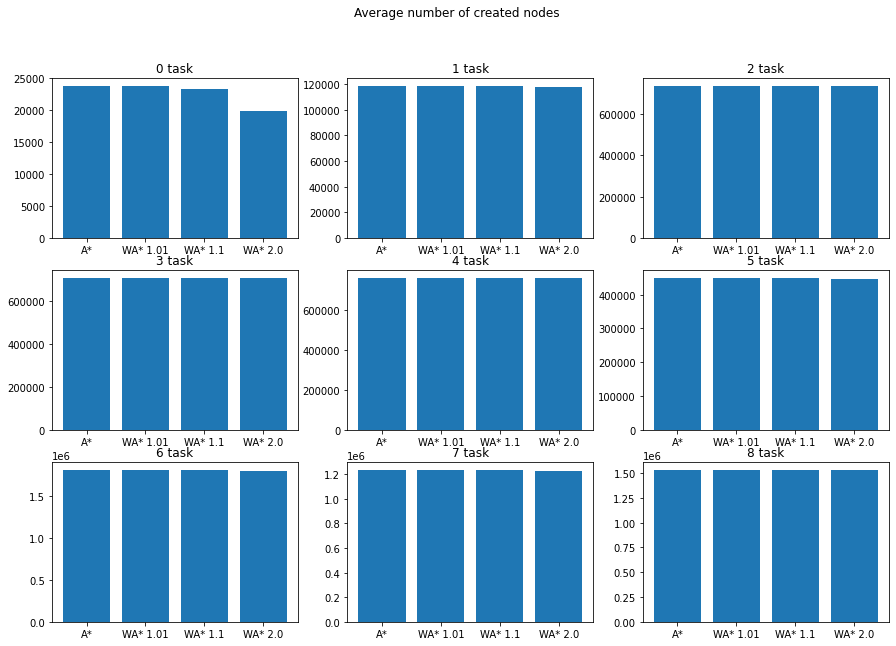

In [101]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
fig.suptitle('Average number of created nodes')
for i in range(9):
    ax = axs[i // 3, i % 3]
    ax.set_title(str(i) + " task")
    alg = ['A*', 'WA* 1.01', 'WA* 1.1', 'WA* 2.0' ]
    lens = [astDiagStat['nc'][i], wastDiagStat101['nc'][i], wastDiagStat11['nc'][i], wastDiagStat2['nc'][i]]
    ax.bar(alg, lens)
plt.show()

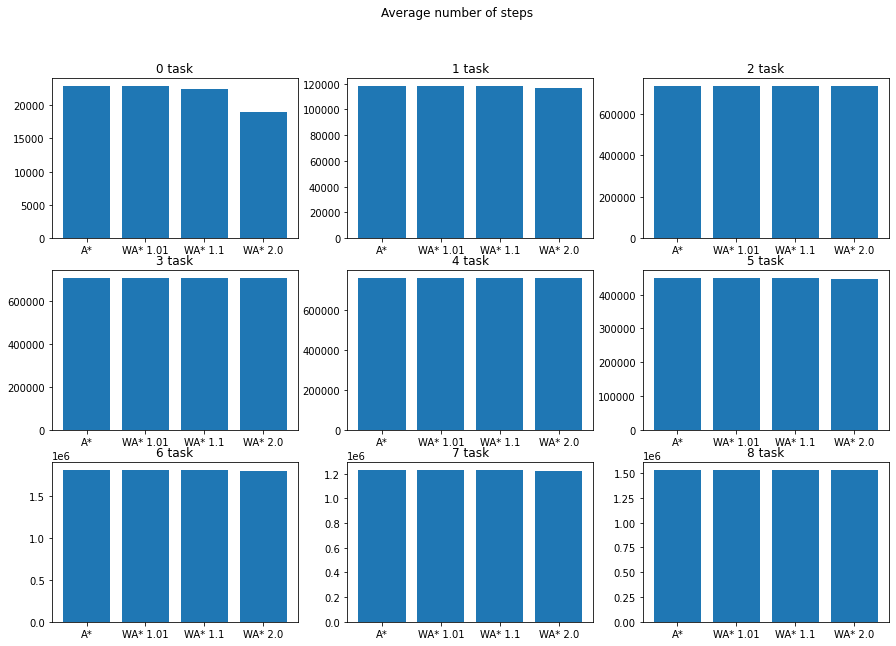

In [102]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
fig.suptitle('Average number of steps')
for i in range(9):
    ax = axs[i // 3, i % 3]
    ax.set_title(str(i) + " task")
    alg = ['A*', 'WA* 1.01', 'WA* 1.1', 'WA* 2.0' ]
    lens = [astDiagStat['st'][i], wastDiagStat101['st'][i], wastDiagStat11['st'][i], wastDiagStat2['st'][i]]
    ax.bar(alg, lens)
plt.show()